# Question 1: Changes year to year

This notebook aims to answer the fifth question of the project.

Year to year:

- Has there been an overall increase or reduction in crime?

- Has a certain type of offence seen a significant decrease or increase?

## Initial setup

In [1]:
# Dependencies
from pathlib import Path 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings

# silence correlation constant input warning
warnings.simplefilter('ignore', st.ConstantInputWarning)
# change plot style
plt.style.use('bmh')

In [2]:
# Define function to get correlation from two columns of a dataframe
def corr_from_df(col_name1, col_name2, df):
    try:
        a = df[col_name1].astype(float)
        b = df[col_name2].astype(float)

        correlation = st.pearsonr(a, b)
        return correlation
    # exception handling: if there is only one value
    except ValueError:
        return [float('nan'), float('nan')]

# Define function to print correlation from two columns of a dataframe
def print_corr_from_df(col_name1, col_name2, df):
    correlation = corr_from_df(col_name1, col_name2, df)
    # because we are rounding the p value to 3 decimal places,
    # if it is less than 0.001, print that instead of the actual value
    if correlation[1] < 0.001:
        print(f"The Pearson's correlation for {col_name1} and {col_name2} is:\n\
        \t{correlation[0]:.2f}\t(p < 0.001)\n")
    else:
        print(f"The Pearson's correlation for {col_name1} and {col_name2} is:\n\
        \t{correlation[0]:.2f}\t(p = {correlation[1]:.3f})\n")

In [3]:
# Read in data
df = pd.read_csv(Path('..', 'resources', 'mci_no_duplicates_2014_and_over.csv'))

# Keep only the relevant columns, rename them and drop na
df = (df[['OCC_YEAR', 'LOCATION_TYPE', 'PREMISES_TYPE', 'OFFENCE', 'MCI_CATEGORY']]
    .rename(
        columns={
            'OCC_YEAR': 'Year',
            'LOCATION_TYPE': 'Location Type',
            'PREMISES_TYPE': 'Premises Type',
            'MCI_CATEGORY': 'Category',
            'OFFENCE': 'Offence',
        }
    )
)


# Make year a string and drop the .0 at the end
df['Year'] = (df['Year']
    .astype('string')
    .str.replace('.0', '',regex=False)
)
# Check dataframe
df.head()

,Year,Location Type,Premises Type,Offence,Category
0,2014,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",Commercial,B&E,Break and Enter
1,2014,"Apartment (Rooming House, Condo)",Apartment,Assault,Assault
2,2014,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Theft Over,Theft Over
3,2014,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Assault,Assault
4,2014,Bar / Restaurant,Commercial,Assault Bodily Harm,Assault


## Total annual counts

We calculate the total number of crime events that happened each year, as well as the percentage change year on year. Then, we calculate the correlation between year and number of events, and plot both number of events and percentage change.

In [4]:
# general counts by year
year_df = (df
    .groupby('Year', as_index=False)
    .size()
    .rename(columns={'size': 'Number of events'})
)

year_df['Percentage Change'] = (year_df['Number of events'].pct_change()) * 100

year_df

,Year,Number of events,Percentage Change
0,2014,30202,NaN
1,2015,30641,1.453546
2,2016,31157,1.684018
3,2017,32790,5.241198
4,2018,34772,6.044526
5,2019,37114,6.735304
6,2020,32456,-12.550520
7,2021,32114,-1.053734
8,2022,37226,15.918291


The Pearson's correlation for Year and Number of events is:
        	0.68	(p = 0.043)



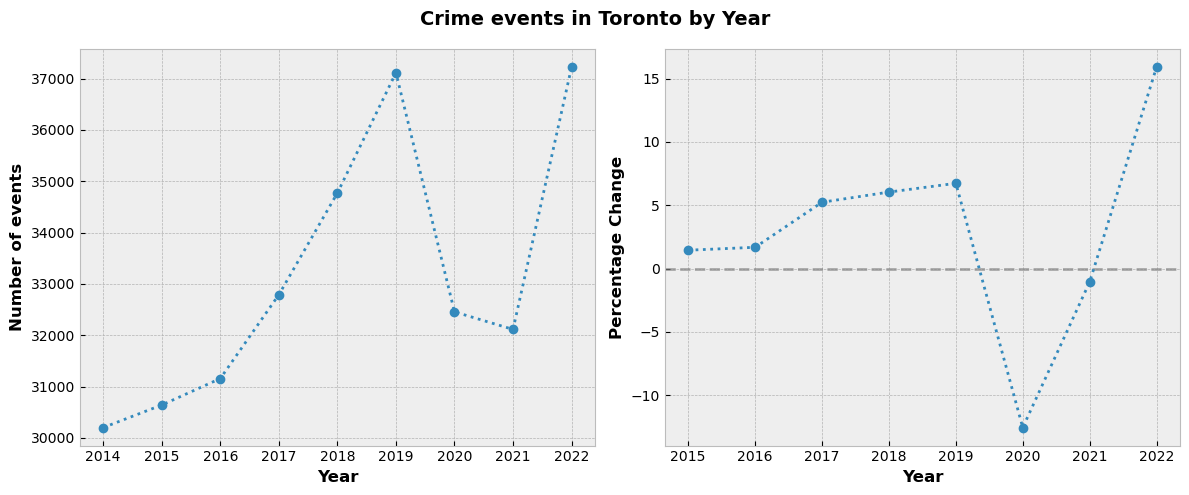

In [5]:
print_corr_from_df('Year', 'Number of events', year_df)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

ax2.axhline(color='grey', linestyle='--', alpha=0.65)


for ax in [ax1, ax2]:
    if ax is ax1:
        col = 'Number of events'
    else:
        col = 'Percentage Change'


    ax.plot(
        year_df['Year'],
        year_df[col],
        'o:',
        label = col
    )
    ax.set_xlabel('Year', fontdict={'weight': 700})
    ax.set_ylabel(col, fontdict={'weight': 700})

fig.suptitle(
    t='Crime events in Toronto by Year',
    fontweight=700, fontsize=14
)

plt.tight_layout()

plt.show()

## By category

In [6]:
# count by category and year
year_cat_df = (df
    .groupby(['Year', 'Category'], as_index=False)
    .size()
    .rename(columns={'size': 'Number of events'})
)

cats = list(year_cat_df['Category'].unique())

year_cat_df['Percentage Change'] = (year_cat_df['Number of events'].pct_change(periods=5)) * 100

year_cat_df.head(10)

,Year,Category,Number of events,Percentage Change
0,2014,Assault,15294,NaN
1,2014,Auto Theft,3485,NaN
2,2014,Break and Enter,7216,NaN
3,2014,Robbery,3193,NaN
4,2014,Theft Over,1014,NaN
5,2015,Assault,16547,8.192755
6,2015,Auto Theft,3090,-11.334290
7,2015,Break and Enter,6934,-3.907982
8,2015,Robbery,3028,-5.167554
9,2015,Theft Over,1042,2.761341


Category: Assault
The Pearson's correlation for Year and Number of events is:
        	0.62	(p = 0.077)

Category: Auto Theft
The Pearson's correlation for Year and Number of events is:
        	0.88	(p = 0.002)

Category: Break and Enter
The Pearson's correlation for Year and Number of events is:
        	-0.32	(p = 0.408)

Category: Robbery
The Pearson's correlation for Year and Number of events is:
        	-0.73	(p = 0.026)

Category: Theft Over
The Pearson's correlation for Year and Number of events is:
        	0.67	(p = 0.048)



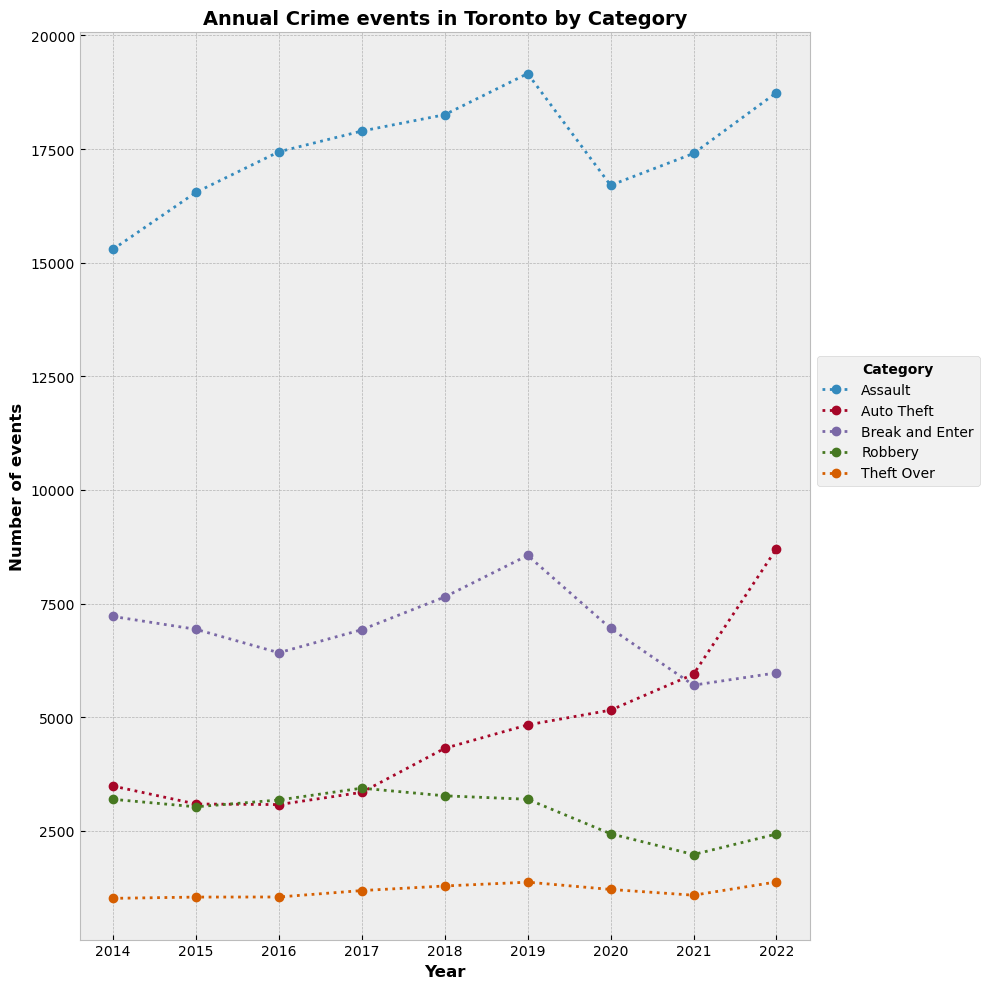

In [7]:
# Visualize
fig, ax = plt.subplots(figsize=(10,10))

ax2.axhline(color='grey', linestyle='--', alpha=0.65)

for cat in cats:
    this_data = year_cat_df.loc[year_cat_df['Category'] == cat]

    print(f"Category: {cat}")
    print_corr_from_df('Year', 'Number of events', this_data)

    # add this category to plot
    ax.plot(
        this_data['Year'],
        this_data['Number of events'],
        'o:',
        label=cat
    )


ax.set_xlabel('Year', fontdict={'weight': 700})
ax.set_ylabel('Number of events', fontdict={'weight': 700})
ax.set_title('Annual Crime events in Toronto by Category', fontdict={'weight': 700, 'size': 14})


ax.legend(
    loc=(1.01, 0.5),
    title='Category',
    title_fontproperties={'weight': 700}
)

plt.tight_layout()

plt.show()

## By premises type

In [8]:
year_premises_df = (df
    .groupby(['Year', 'Premises Type'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

year_premises_df

,Year,Premises Type,Number of events
0,2014,Apartment,7421
1,2014,Commercial,5452
2,2014,Educational,942
3,2014,House,6196
4,2014,Other,1554
...,...,...,...
58,2022,Educational,734
59,2022,House,6805
60,2022,Other,2398
61,2022,Outside,10273


Premises type: Apartment
The Pearson's correlation for Year and Number of events is:
        	0.52	(p = 0.155)

Premises type: Commercial
The Pearson's correlation for Year and Number of events is:
        	0.59	(p = 0.092)

Premises type: Educational
The Pearson's correlation for Year and Number of events is:
        	-0.62	(p = 0.075)



Premises type: House
The Pearson's correlation for Year and Number of events is:
        	0.09	(p = 0.818)

Premises type: Other
The Pearson's correlation for Year and Number of events is:
        	0.86	(p = 0.003)

Premises type: Outside
The Pearson's correlation for Year and Number of events is:
        	0.71	(p = 0.032)

Premises type: Transit
The Pearson's correlation for Year and Number of events is:
        	0.96	(p < 0.001)



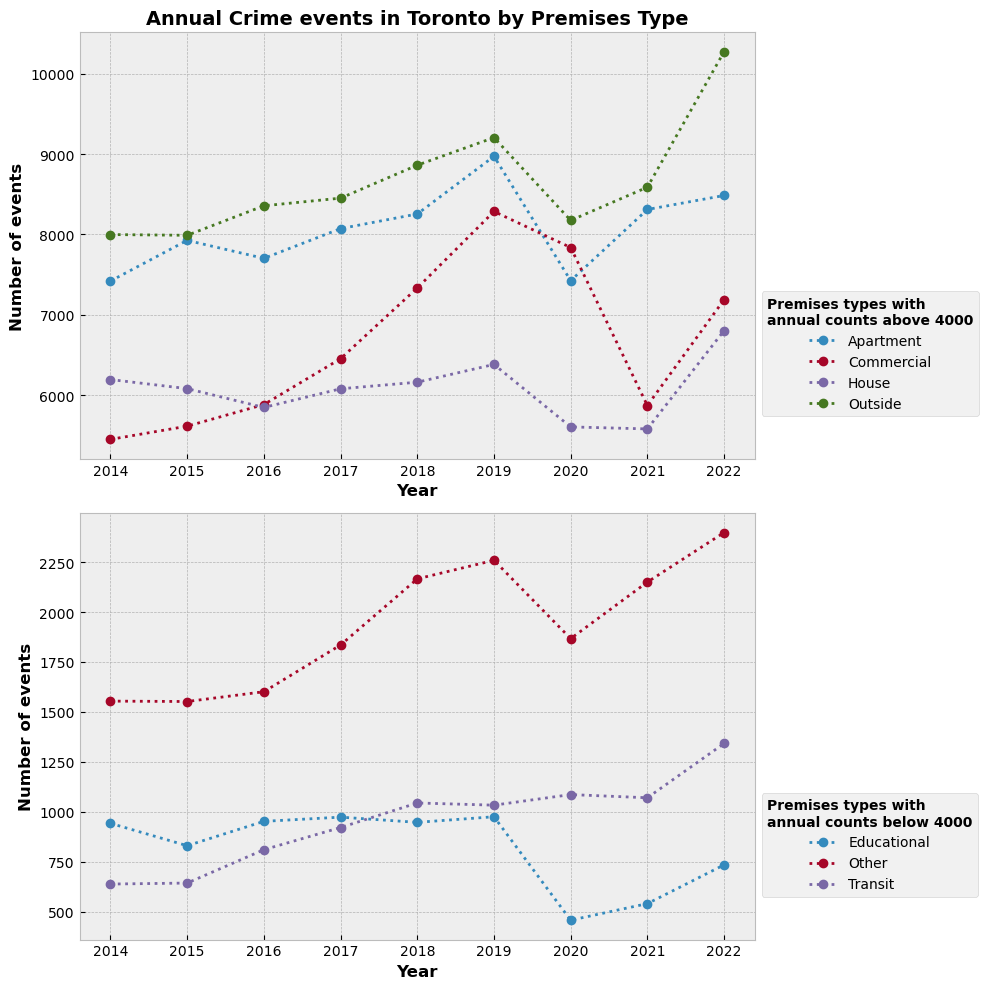

In [20]:
# Visualize

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))


mid_lim = 4000

# List of premises types
premises = list(year_premises_df['Premises Type'].unique())

for idx, prem in enumerate(premises):
    this_data = year_premises_df.loc[year_premises_df['Premises Type'] == prem]

    
    print(f"Premises type: {prem}")
    print_corr_from_df('Year', 'Number of events', this_data)



    if max(this_data['Number of events']) < mid_lim:
        ax = ax2
    else:
        ax = ax1

    ax.plot(
        this_data['Year'],
        this_data['Number of events'],
        'o:',
        label=prem
    )
for ax in [ax1, ax2]:
    if ax is ax1:
        direction = ' above '
    else:
        direction = ' below '

    ax.legend(
        loc=(1.01, 0.1),
        title='Premises types with\nannual counts' + direction + str(mid_lim),
        title_fontproperties={'weight': 700}
    )
    
    ax.set_ylabel(
        'Number of events' ,
        fontdict={'weight': 700}
    )
    
    
    ax.set_xlabel('Year', fontdict={'weight': 700})



ax1.set_title(
    'Annual Crime events in Toronto by Premises Type',
    fontdict={'weight': 700, 'size': 14}
)

plt.tight_layout()
# fig.subplots_adjust(hspace=0)

plt.show()



# Extras: subcategories and location types

## By subcategory

Most interesting: robbery subcategories

In [10]:
year_subcat_df = (df
    .groupby(['Year', 'Category', 'Offence'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

year_subcat_df.head()


,Year,Category,Offence,Number of events
0,2014,Assault,Administering Noxious Thing,29
1,2014,Assault,Aggravated Aslt Peace Officer,1
2,2014,Assault,Aggravated Assault,262
3,2014,Assault,Aggravated Assault Avails Pros,3
4,2014,Assault,Air Gun Or Pistol: Bodily Harm,1


### Break and Enter

Category: Break and Enter
Subcategory: B&E W'Intent
The Pearson's correlation for Year and Number of events is:
        	-0.66	(p = 0.052)



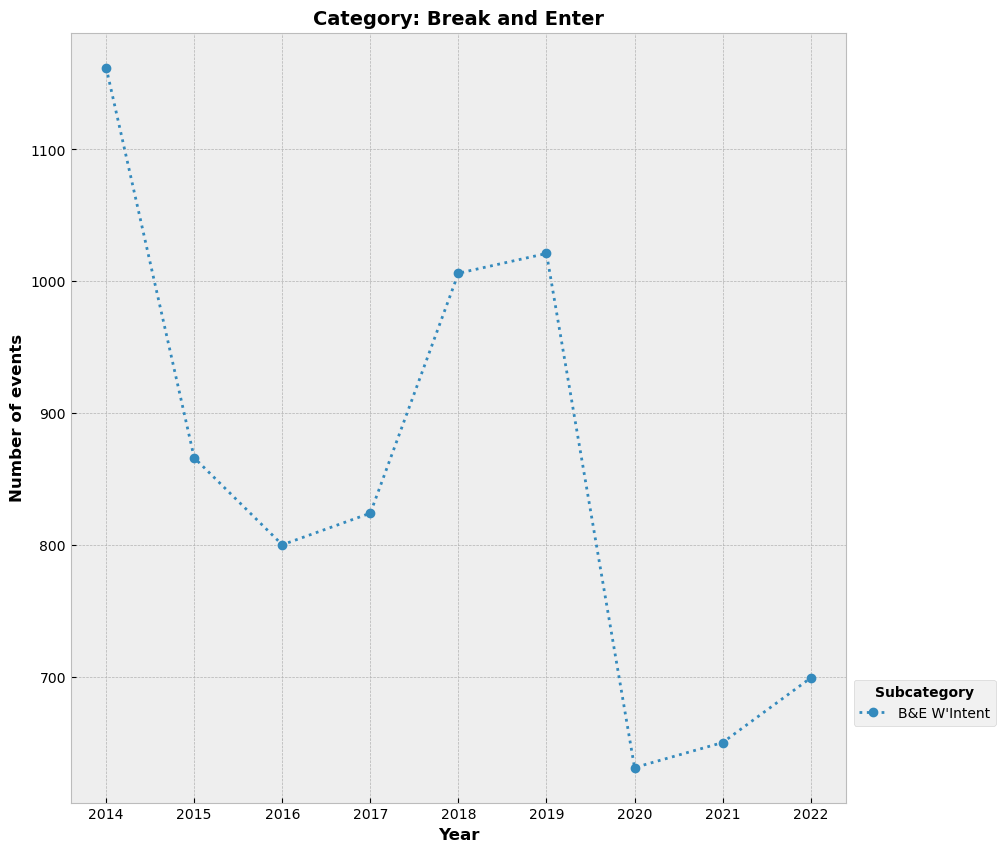

In [11]:
# Visualize
min_count = 0
# only show moderate and
limitcorr = 0.5

cat = cats[2]
this_data = year_subcat_df.loc[year_subcat_df['Category'] == cat]
print(f"Category: {cat}")
offences = list(this_data['Offence'].unique())
fig, ax = plt.subplots(1, figsize=(10, 10))
for offence in offences:
    
    this_data_off = this_data.loc[this_data['Offence'] == offence]


    if any(this_data_off['Number of events'] > min_count):
        correlation = corr_from_df('Year', 'Number of events', this_data_off)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Subcategory: {offence}")
            print_corr_from_df('Year', 'Number of events', this_data_off)
            ax.plot(
                this_data_off['Year'],
                this_data_off['Number of events'],
                'o:',
                label=offence
            )
ax.legend(
    loc=(1.01, 0.1),
    title='Subcategory',
    title_fontproperties={'weight': 700}
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    'Category: ' + cat,
    fontdict={'weight': 700, 'size': 14}
)
ax.set_xlabel('Year', fontdict={'weight': 700})

ax.set_ylabel('Number of events', fontdict={'weight': 700})

plt.show()



### Robbery

Category: Robbery
Subcategory: Robbery - Business
The Pearson's correlation for Year and Number of events is:
        	0.79	(p = 0.011)

Subcategory: Robbery - Financial Institute
The Pearson's correlation for Year and Number of events is:
        	-0.59	(p = 0.096)

Subcategory: Robbery - Home Invasion
The Pearson's correlation for Year and Number of events is:
        	-0.86	(p = 0.003)

Subcategory: Robbery - Mugging
The Pearson's correlation for Year and Number of events is:
        	-0.94	(p < 0.001)

Subcategory: Robbery - Other
The Pearson's correlation for Year and Number of events is:
        	-0.73	(p = 0.026)

Subcategory: Robbery - Purse Snatch
The Pearson's correlation for Year and Number of events is:
        	-0.94	(p < 0.001)

Subcategory: Robbery - Swarming
The Pearson's correlation for Year and Number of events is:
        	-0.91	(p < 0.001)

Subcategory: Robbery - Taxi
The Pearson's correlation for Year and Number of events is:
        	-0.83	(p = 0.006)

Subcategory

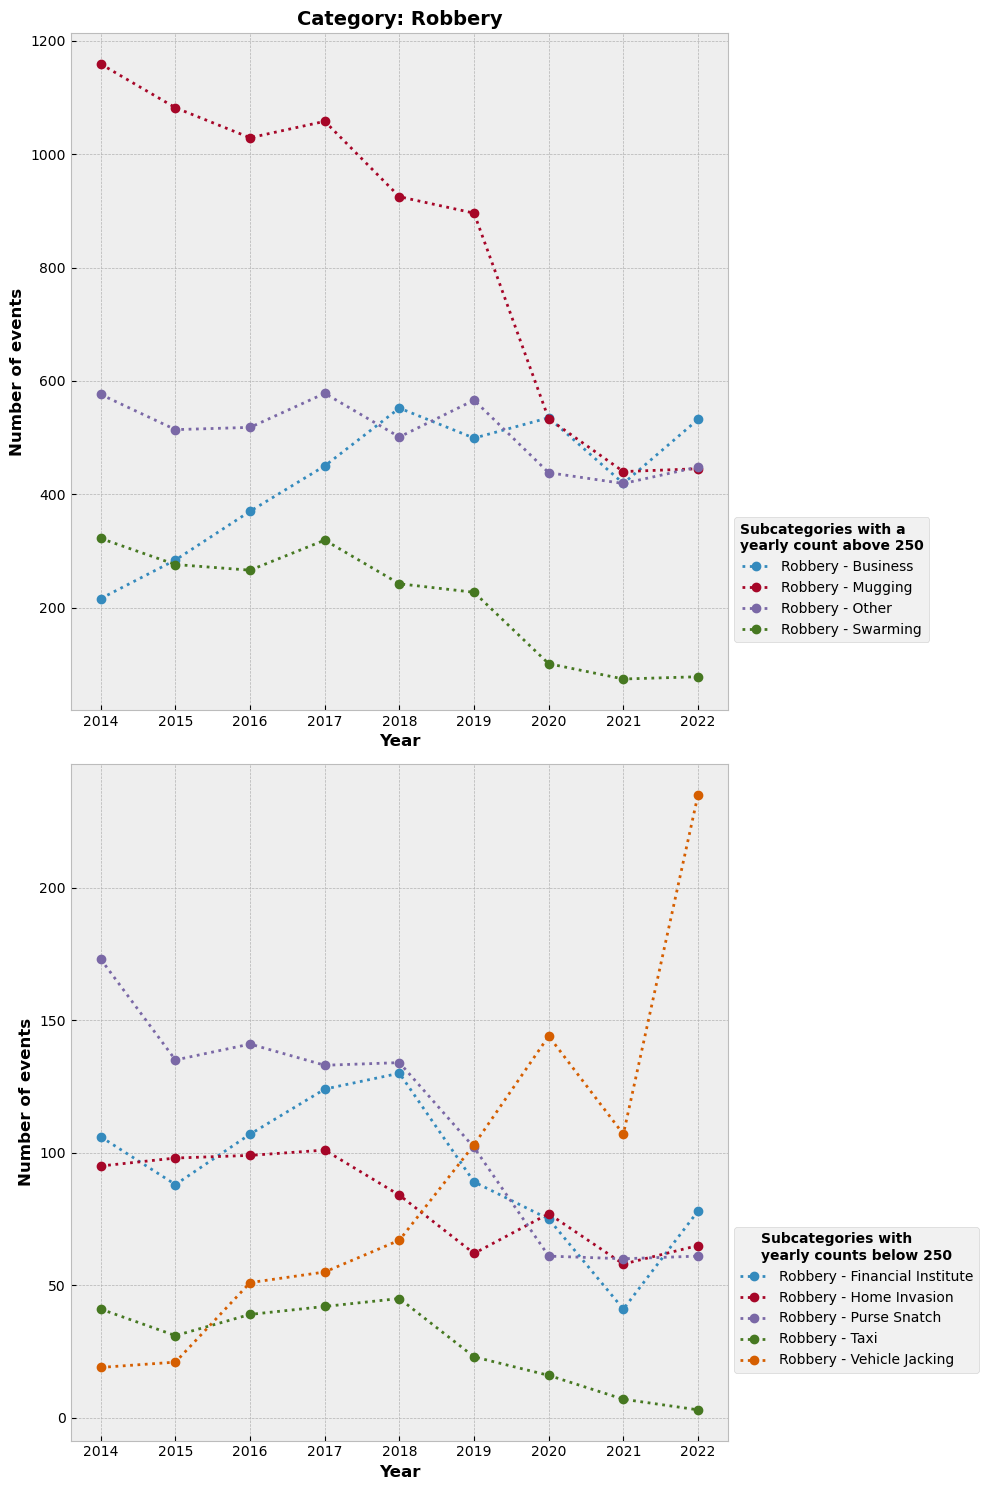

In [12]:
# Visualize
min_count = 0
mid_lim = 250
# max_count = max(year_offence_count['Number of events']) + 1
# only show moderate and
limitcorr = 0.5

cat = cats[3]
this_data = year_subcat_df.loc[year_subcat_df['Category'] == cat]
print(f"Category: {cat}")
offences = list(this_data['Offence'].unique())
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 15))
for offence in offences:
    
    this_data_off = this_data.loc[this_data['Offence'] == offence]


    if any(this_data_off['Number of events'] > min_count):
        if max(this_data_off['Number of events']) < mid_lim:
            ax = ax2
        else:
            ax = ax1


        
        correlation = corr_from_df('Year', 'Number of events', this_data_off)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Subcategory: {offence}")
            print_corr_from_df('Year', 'Number of events', this_data_off)
            ax.plot(
                this_data_off['Year'],
                this_data_off['Number of events'],
                'o:',
                label=offence
            )

for ax in [ax1, ax2]:
    if ax is ax1:
        legend_title = 'Subcategories with a\nyearly count above ' + str(mid_lim)
    else:
        legend_title = 'Subcategories with \nyearly counts below ' + str(mid_lim)

    ax.legend(
        loc=(1.01, 0.1),
        title=legend_title,
        title_fontproperties={'weight': 700}
    )
    
    ax.set_ylabel(
        'Number of events' ,
        fontdict={'weight': 700}
    )
    
    
    ax.set_xlabel('Year', fontdict={'weight': 700})

ax1.set_title(
        'Category: ' + cat,
        fontdict={'weight': 700, 'size': 14}
    )

plt.tight_layout()

plt.show()



### Theft Over

Category: Theft Over 5000 CAD
Subcategory: Theft From Mail / Bag / Key
The Pearson's correlation for Year and Number of events is:
        	0.68	(p = 0.042)

Subcategory: Theft From Motor Vehicle Over
The Pearson's correlation for Year and Number of events is:
        	0.80	(p = 0.009)

Subcategory: Theft Over - Bicycle
The Pearson's correlation for Year and Number of events is:
        	-0.58	(p = 0.169)



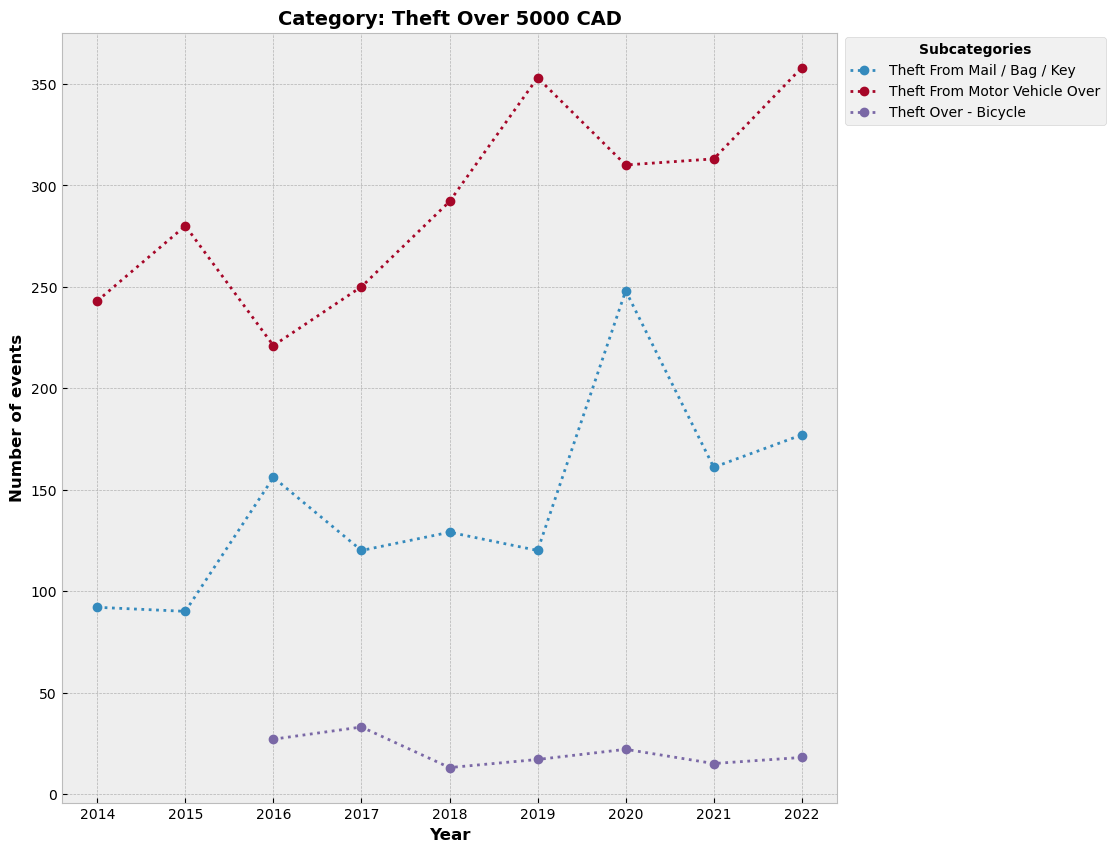

In [13]:
# Visualize

min_count = 5
# only show moderate and high correlations
limitcorr = 0.5

cat = cats[4]
this_data = year_subcat_df.loc[year_subcat_df['Category'] == cat]
print(f"Category: {cat} 5000 CAD")
offences = list(this_data['Offence'].unique())
fig, ax = plt.subplots(1, figsize=(10, 10))
for offence in offences:

    this_data_off = this_data.loc[this_data['Offence'] == offence]

    if any(this_data_off['Number of events'] > min_count):
        correlation = corr_from_df('Year', 'Number of events', this_data_off)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Subcategory: {offence}")
            print_corr_from_df('Year', 'Number of events', this_data_off)
            ax.plot(
                this_data_off['Year'],
                this_data_off['Number of events'],
                'o:',
                label=offence
            )
ax.legend(loc=(1.01, 0.88), title='Subcategories', title_fontproperties={'weight': 700})

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    'Category: ' + cat + ' 5000 CAD',
    fontdict={'weight': 700, 'size': 14}
)
ax.set_xlabel('Year', fontdict={'weight': 700})

ax.set_ylabel('Number of events', fontdict={'weight': 700})

plt.show()



## By location type

Most interesting: Transit and Other location types

In [14]:
year_loc_df = (df
    .groupby(['Year', 'Premises Type', 'Location Type'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)
premises = list(year_loc_df['Premises Type'].unique())
year_loc_df

,Year,Premises Type,Location Type,Number of events
0,2014,Apartment,"Apartment (Rooming House, Condo)",7421
1,2014,Commercial,Bank And Other Financial Institutions (Money M...,191
2,2014,Commercial,Bar / Restaurant,1278
3,2014,Commercial,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",395
4,2014,Commercial,"Construction Site (Warehouse, Trailer, Shed)",193
...,...,...,...,...
437,2022,Transit,Ttc Street Car,71
438,2022,Transit,Ttc Subway Station,599
439,2022,Transit,Ttc Subway Train,175
440,2022,Transit,Ttc Subway Tunnel / Outdoor Tracks,4


### Commercial

Premises Type: Commercial
Location type: Construction Site (Warehouse, Trailer, Shed)


The Pearson's correlation for Year and Number of events is:
        	0.85	(p = 0.004)

Location type: Convenience Stores
The Pearson's correlation for Year and Number of events is:
        	0.66	(p = 0.053)

Location type: Dealership (Car, Motorcycle, Marine, Trailer, Etc.)
The Pearson's correlation for Year and Number of events is:
        	0.80	(p = 0.010)

Location type: Gas Station (Self, Full, Attached Convenience)
The Pearson's correlation for Year and Number of events is:
        	0.88	(p = 0.002)



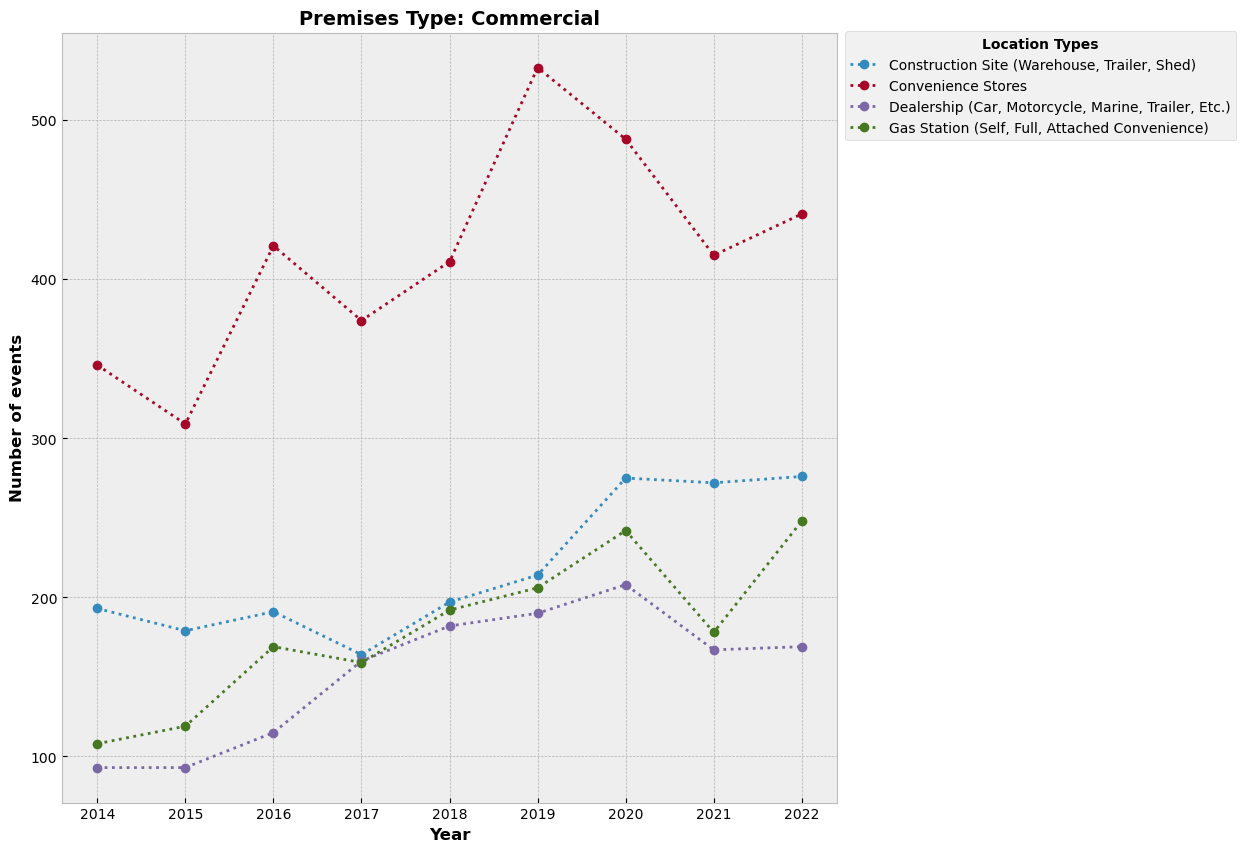

In [15]:
# Visualize
max_count = 2000
# only show moderate and
limitcorr = 0.5

prem = premises[1]
this_data = year_loc_df.loc[year_loc_df['Premises Type'] == prem]
print(f"Premises Type: {prem}")

locations = list(this_data['Location Type'].unique())
fig, ax = plt.subplots(1, figsize=(10, 10))
for location in locations:
    this_data_location = this_data.loc[this_data['Location Type'] == location]

    if any(this_data_location['Number of events'] < max_count):
        correlation = corr_from_df('Year', 'Number of events', this_data_location)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Location type: {location}")
            print_corr_from_df('Year', 'Number of events', this_data_location)
            # add this offence to plot
            ax.plot(
                this_data_location['Year'],
                
                this_data_location['Number of events'],
                'o:',
                label=location
            )

ax.legend(loc=(1.01, 0.86), title='Location Types', title_fontproperties={'weight': 700})

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    'Premises Type: ' + prem,
    fontdict={'weight': 700, 'size': 14}
)
ax.set_xlabel('Year', fontdict={'weight': 700})

ax.set_ylabel('Number of events', fontdict={'weight': 700})

plt.show()


### Educational

Premises Type: Educational
Location type: Schools During Supervised Activity
The Pearson's correlation for Year and Number of events is:
        	-0.60	(p = 0.089)

Location type: Schools During Un-Supervised Activity
The Pearson's correlation for Year and Number of events is:
        	-0.72	(p = 0.030)



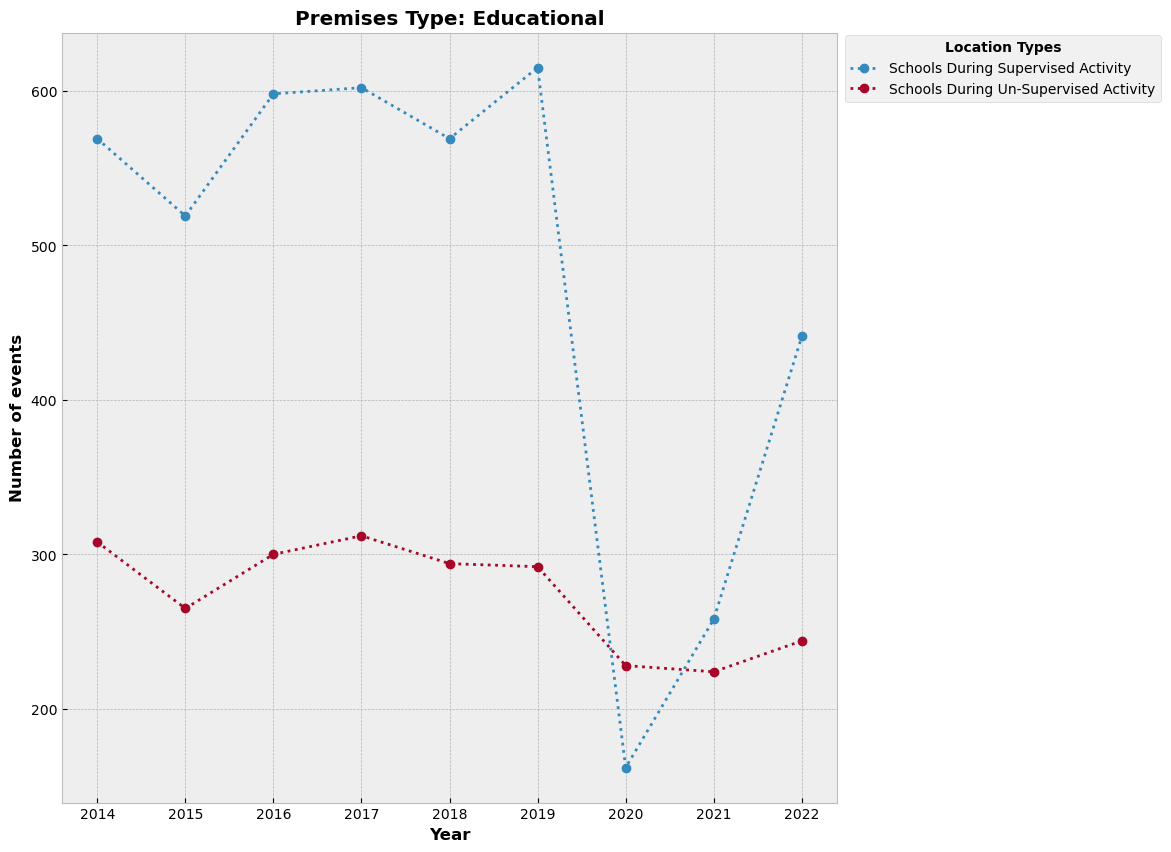

In [16]:
# Visualize
min_count = 100
# only show moderate and
limitcorr = 0.5

prem = premises[2]
this_data = year_loc_df.loc[year_loc_df['Premises Type'] == prem]
print(f"Premises Type: {prem}")

locations = list(this_data['Location Type'].unique())
fig, ax = plt.subplots(1, figsize=(10, 10))
for location in locations:
    this_data_location = this_data.loc[this_data['Location Type'] == location]

    if any(this_data_location['Number of events'] > min_count):
        correlation = corr_from_df('Year', 'Number of events', this_data_location)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Location type: {location}")
            print_corr_from_df('Year', 'Number of events', this_data_location)
            # add this offence to plot
            ax.plot(
                this_data_location['Year'],
                this_data_location['Number of events'],
                'o:',
                label=location
            )

ax.legend(loc=(1.01, 0.91), title='Location Types', title_fontproperties={'weight': 700})

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    'Premises Type: ' + prem,
    fontdict={'weight': 700}
)
ax.set_xlabel('Year', fontdict={'weight': 700})

ax.set_ylabel('Number of events', fontdict={'weight': 700})

plt.show()


### Other premises type

Premises Type: Other
Location type: Group Homes (Non-Profit, Halfway House, Social Agency)
The Pearson's correlation for Year and Number of events is:
        	-0.47	(p = 0.199)

Location type: Homeless Shelter / Mission
The Pearson's correlation for Year and Number of events is:
        	0.92	(p < 0.001)

Location type: Private Property Structure (Pool, Shed, Detached Garage)
The Pearson's correlation for Year and Number of events is:
        	0.92	(p < 0.001)



Location type: Pharmacy
The Pearson's correlation for Year and Number of events is:
        	0.95	(p < 0.001)

Location type: Nursing Home
The Pearson's correlation for Year and Number of events is:
        	-0.75	(p = 0.086)



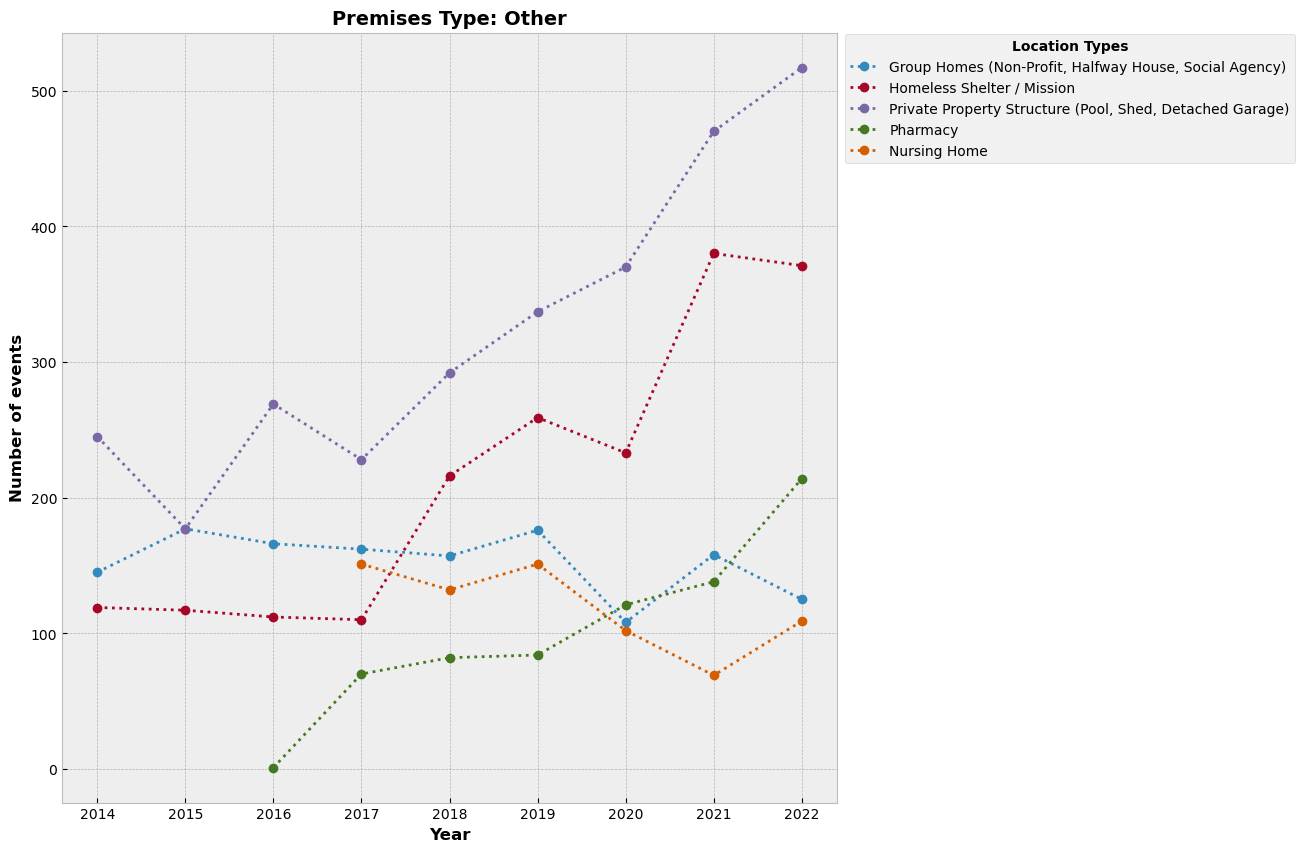

In [17]:
# Visualize
min_count = 125
# only show moderate and
limitcorr = 0.45

prem = premises[4]
this_data = year_loc_df.loc[year_loc_df['Premises Type'] == prem]
print(f"Premises Type: {prem}")

locations = list(this_data['Location Type'].unique())
fig, ax = plt.subplots(1, figsize=(10, 10))
for location in locations:
    this_data_location = this_data.loc[this_data['Location Type'] == location]

    if any(this_data_location['Number of events'] > min_count):
        correlation = corr_from_df('Year', 'Number of events', this_data_location)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Location type: {location}")
            print_corr_from_df('Year', 'Number of events', this_data_location)
            # add this offence to plot
            ax.plot(
                this_data_location['Year'],
                this_data_location['Number of events'],
                'o:',
                label=location
            )

ax.legend(loc=(1.01, 0.83), title='Location Types', title_fontproperties={'weight': 700})

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    'Premises Type: ' + prem,
    fontdict={'weight': 700, 'size': 14}
)
ax.set_xlabel('Year', fontdict={'weight': 700})

ax.set_ylabel('Number of events', fontdict={'weight': 700})

plt.show()


### Outside

Premises Type: Outside
Location type: Open Areas (Lakes, Parks, Rivers)
The Pearson's correlation for Year and Number of events is:
        	-0.59	(p = 0.093)

Location type: Parking Lots (Apt., Commercial Or Non-Commercial)
The Pearson's correlation for Year and Number of events is:
        	0.76	(p = 0.017)



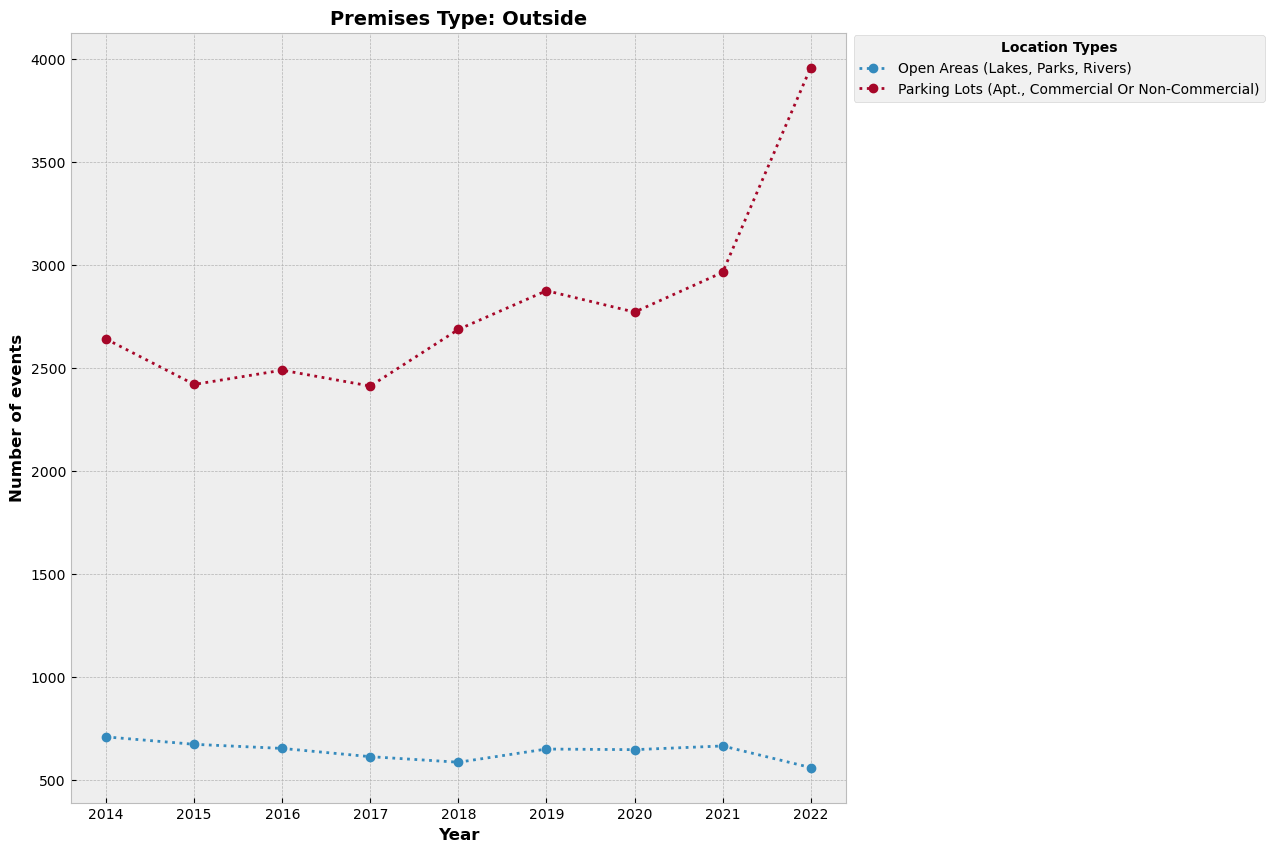

In [18]:
# Visualize
min_count = 0
# only show moderate and
limitcorr = 0.5

prem = premises[5]
this_data = year_loc_df.loc[year_loc_df['Premises Type'] == prem]
print(f"Premises Type: {prem}")

locations = list(this_data['Location Type'].unique())
fig, ax = plt.subplots(1, figsize=(10, 10))
for location in locations:
    this_data_location = this_data.loc[this_data['Location Type'] == location]

    if any(this_data_location['Number of events'] > min_count):
        correlation = corr_from_df(
            'Year', 'Number of events', this_data_location)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Location type: {location}")
            print_corr_from_df('Year', 'Number of events', this_data_location)
            # add this offence to plot
            ax.plot(
                this_data_location['Year'],
                this_data_location['Number of events'],
                'o:',
                label=location
            )

ax.legend(loc=(1.01, 0.91), title='Location Types', title_fontproperties={'weight': 700})

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    'Premises Type: ' + prem,
    fontdict={'weight': 700, 'size': 14}
)
ax.set_xlabel('Year', fontdict={'weight': 700})

ax.set_ylabel('Number of events', fontdict={'weight': 700})

plt.show()


### Transit

Premises Type: Transit
Location type: Go Station
The Pearson's correlation for Year and Number of events is:
        	0.72	(p = 0.027)

Location type: Ttc Bus
The Pearson's correlation for Year and Number of events is:
        	0.71	(p = 0.032)



Location type: Ttc Street Car
The Pearson's correlation for Year and Number of events is:
        	0.72	(p = 0.027)

Location type: Ttc Subway Station
The Pearson's correlation for Year and Number of events is:
        	0.96	(p < 0.001)

Location type: Ttc Subway Train
The Pearson's correlation for Year and Number of events is:
        	0.89	(p = 0.001)



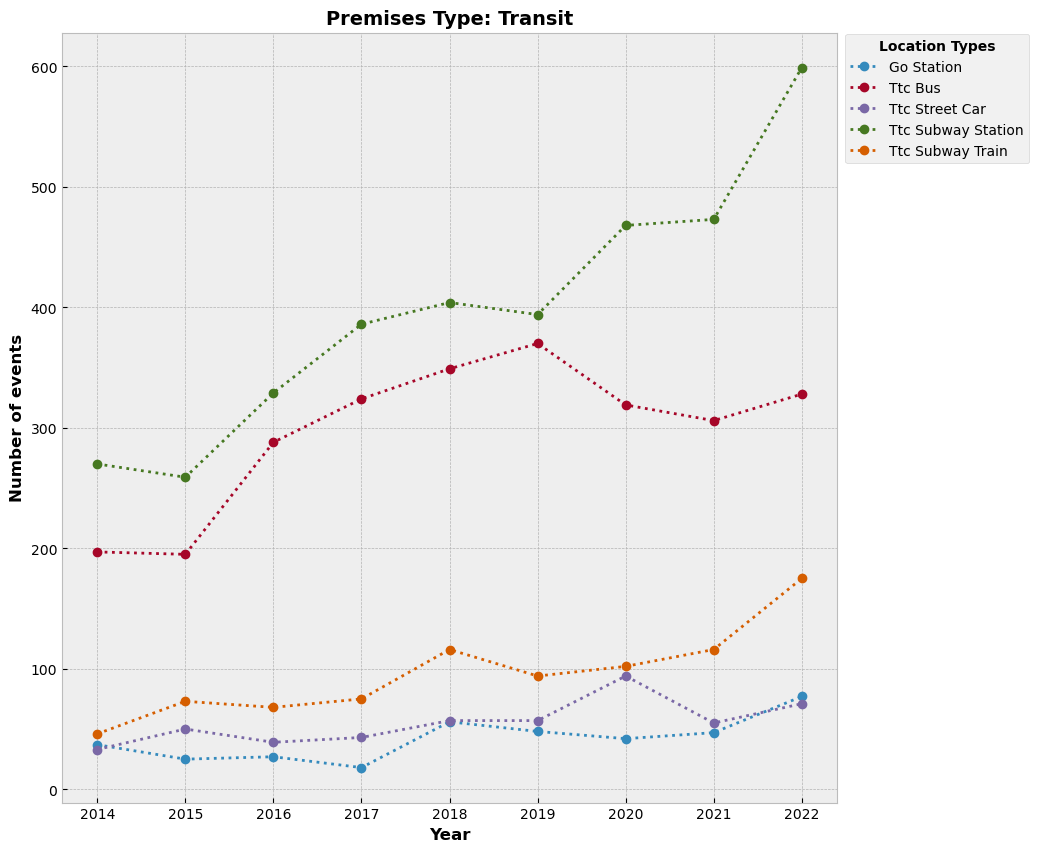

In [19]:
# Visualize
min_count = 30
# only show moderate and
limitcorr = 0.5

prem = premises[6]
this_data = year_loc_df.loc[year_loc_df['Premises Type'] == prem]
print(f"Premises Type: {prem}")

locations = list(this_data['Location Type'].unique())
fig, ax = plt.subplots(1, figsize=(10, 10))
for location in locations:
    this_data_location = this_data.loc[this_data['Location Type'] == location]

    if any(this_data_location['Number of events'] > min_count):
        correlation = corr_from_df('Year', 'Number of events', this_data_location)
        if correlation[0] ** 2 >= limitcorr ** 2:
            print(f"Location type: {location}")
            print_corr_from_df('Year', 'Number of events', this_data_location)
            # add this offence to plot
            ax.plot(
                this_data_location['Year'],
                this_data_location['Number of events'],
                'o:',
                label=location
            )

ax.legend(loc=(1.01, 0.83), title='Location Types', title_fontproperties={'weight': 700})

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(
    'Premises Type: ' + prem,
    fontdict={'weight': 700, 'size': 14}
)
ax.set_xlabel('Year', fontdict={'weight': 700})

ax.set_ylabel('Number of events', fontdict={'weight': 700})

plt.show()


# Question 2: Peak times for crime occurrances

This notebook aims to answer the second question of the project.

In general:

- What are the peak times for crime occurences?

- Does it change according to season?

- Is there a concentration of crime around a specific period of the year?



## Initial setup

In [ ]:
# Dependencies

from pathlib import Path 
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st


In [ ]:
# plt.style.use('Solarize_Light2')
plt.style.use('bmh')

After loading the dependencies, we read in the data, select the columns we need for the analysis and rename them. We also make the year column a string and convert the columns of Month and Day of the Week into ordered categorical variables, so they keep their order when plotting.

In [ ]:
# Read in data
df = pd.read_csv(Path('..', 'resources', 'mci_no_duplicates_2014_and_over.csv'))

# Keep only the relevant columns, rename them and drop na
df = (df[['OCC_YEAR', 'OCC_MONTH', 'OCC_DAY', 'OCC_DOW', 'OCC_HOUR', 'MCI_CATEGORY', 'OFFENCE']]
    .rename(
        columns={
            'OCC_YEAR': 'Year',
            'OCC_MONTH': 'Month',
            'OCC_DAY': 'Day',
            'OCC_DOW': 'Weekday',
            'OCC_HOUR': 'Hour',
            'MCI_CATEGORY': 'Category',
            'OFFENCE': 'Offence',
        }
    )
)


# Make year a string 
df['Year'] = (df['Year']
    .astype('string')
    .str.replace('.0', '',regex=False)
)


# Make month an ordered categorical variable
df['Month'] = (df['Month']
    .astype(
        CategoricalDtype(
            categories=[
                'January',
                'February',
                'March',
                'April',
                'May',
                'June',
                'July',
                'August',
                'September',
                'October',
                'November',
                'December'
            ],
            ordered=True))
)

# Make day of the week an ordered categorical variable
df['Weekday'] = (df['Weekday']
    .str.strip()
    .astype(
        CategoricalDtype(
            categories=[
                'Monday',
                'Tuesday',
                'Wednesday',
                'Thursday',
                'Friday',
                'Saturday',
                'Sunday'
            ],
            ordered=True)
    )
)

df.head()

,Year,Month,Day,Weekday,Hour,Category,Offence
0,2014,January,1.0,Wednesday,3.0,Break and Enter,B&E
1,2014,January,1.0,Wednesday,4.0,Assault,Assault
2,2014,January,1.0,Wednesday,4.0,Theft Over,Theft Over
3,2014,January,1.0,Wednesday,4.0,Assault,Assault
4,2014,January,1.0,Wednesday,2.0,Assault,Assault Bodily Harm


## Calculate daily and hourly counts

We count the number of crime events in general and by category for each date, as well as for each hour. This will allow us to aggregate and visualize the data by month, day of the week and hour of the day.


In [ ]:
# create a df with all dates and their weekday to join later
dates = df[['Year', 'Month', 'Day', 'Weekday']].drop_duplicates()
dates

In [ ]:
# Get general daily counts
daily_count = (df
    .groupby(['Year', 'Month', 'Day'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Daily count'})
    .merge(dates, how='left', on= ['Year', 'Month', 'Day'])
)
daily_count.head()

In [ ]:
# Get daily counts by category
daily_count_cat = (df
    .groupby(['Year', 'Month', 'Day', 'Category'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Daily count'})
    .merge(dates, how='left', on= ['Year', 'Month', 'Day'])
)
daily_count_cat.head()

In [ ]:
# Get general hourly counts
hour_count = (df
    .groupby(['Year', 'Month', 'Day', 'Hour'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Hourly count'})
    .merge(dates, how='left', on= ['Year', 'Month', 'Day'])
)
hour_count.head()

In [ ]:
# Get hourly counts by category
hour_count_cat = (df
    .groupby(
        ['Year', 'Month', 'Day', 'Hour', 'Category'],
        as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Hourly count'})
    .merge(dates, how='left', on= ['Year', 'Month', 'Day'])
)
hour_count_cat.head()

## By month

In [ ]:
# Get average daily counts by month
month_df = (daily_count
    .groupby('Month', as_index=False)
    .agg(daily_average=('Daily count', 'mean'))
)
month_df

In [ ]:

fig, ax = plt.subplots()
ax.plot(
    month_df['Month'],
    month_df['daily_average'],
    'o:'
)

plt.xlabel('Month', fontdict={'weight': 700})
plt.ylabel('Average of daily count', fontdict={'weight': 700})
plt.title(
    'Monthly Average of Daily Crime Events in Toronto',
    fontdict={'weight': 700}
    )
plt.xticks(
    ticks=np.arange(12),
    labels=[m[0:3] for m in month_df['Month']]
)

plt.show()

In [ ]:
# Get monthly average for each individual month/year
day_av_by_month = (daily_count
    .groupby(['Year', 'Month'], as_index=False)
    .agg(monthly_daily_average=('Daily count', 'mean'))
)
day_av_by_month

In [ ]:
# Visualize monthly averages in a boxplot

fig, ax = plt.subplots()

day_av_by_month.boxplot(
    'monthly_daily_average',
    by='Month',
    positions=np.arange(12),
    ax=ax

)

ax.plot(
    month_df['Month'],
    month_df['daily_average'],
    'o:',
    label='mean',
    zorder=3
)

fig.suptitle('')

plt.legend(loc='lower right')

plt.xlabel('Month', fontdict={'weight': 700})
plt.ylabel('Average of daily count', fontdict={'weight': 700})
plt.title(
    'Monthly Average of Daily Crime Events in Toronto',
    fontdict={'weight': 700, 'size': 14}
    )
# plt.xlabel('Month')
# plt.ylabel('Average of daily count')
# plt.title('Monthly Average of Daily Crime Events in Toronto')

plt.xticks(
    ticks=np.arange(12),
    labels=[m[0:3] for m in month_df['Month']]
)

plt.show()

In [ ]:
jan = day_av_by_month.loc[day_av_by_month['Month']=='January']['monthly_daily_average']
feb = day_av_by_month.loc[day_av_by_month['Month']=='February']['monthly_daily_average']
mar = day_av_by_month.loc[day_av_by_month['Month']=='March']['monthly_daily_average']
apr = day_av_by_month.loc[day_av_by_month['Month']=='April']['monthly_daily_average']
may = day_av_by_month.loc[day_av_by_month['Month']=='May']['monthly_daily_average']
jun = day_av_by_month.loc[day_av_by_month['Month']=='June']['monthly_daily_average']
jul = day_av_by_month.loc[day_av_by_month['Month']=='July']['monthly_daily_average']
aug = day_av_by_month.loc[day_av_by_month['Month']=='August']['monthly_daily_average']
sep = day_av_by_month.loc[day_av_by_month['Month']=='September']['monthly_daily_average']
octb = day_av_by_month.loc[day_av_by_month['Month']=='October']['monthly_daily_average']
nov = day_av_by_month.loc[day_av_by_month['Month']=='November']['monthly_daily_average']
dec = day_av_by_month.loc[day_av_by_month['Month']=='December']['monthly_daily_average']

In [ ]:
st.f_oneway(jan, feb, mar, apr, may, jun, jul, aug, sep, octb, nov, dec)

In [ ]:
# https://stackoverflow.com/a/19960116
q1 = day_av_by_month.loc[day_av_by_month.Month.isin(['January', 'February', 'March'])]['monthly_daily_average']
q2 = day_av_by_month.loc[day_av_by_month.Month.isin(['April', 'May', 'June'])]['monthly_daily_average']
q3 = day_av_by_month.loc[day_av_by_month.Month.isin(['July', 'August', 'September'])]['monthly_daily_average']
q4 = day_av_by_month.loc[day_av_by_month.Month.isin(['October', 'November', 'December'])]['monthly_daily_average']

In [ ]:
[x.mean() for x in [q1, q2, q3, q4]]

In [ ]:
fig, ax = plt.subplots()


plt.boxplot(
    [q1, q2, q3, q4],
    labels=['Q1', 'Q2', 'Q3', 'Q4'],
    positions=np.arange(4)
)


ax.plot(
    ['Q1', 'Q2', 'Q3', 'Q4'],
    [x.mean() for x in [q1, q2, q3, q4]],
    'o:',
    label='mean',
    zorder=3
)

fig.suptitle('')

plt.legend(loc='lower right')

plt.xlabel('Quarter', fontdict={'weight': 700})
plt.ylabel('Average of daily count', fontdict={'weight': 700})
plt.title(
    'Quarter Average of Daily Crime Events in Toronto',
    fontdict={'weight': 700, 'size': 14}
    )


plt.show()


plt.show()

In [ ]:
st.f_oneway(q1, q2, q3, q4)

**Conclusion:** The month has an effect on the number of daily crime events in Toronto. Crimes are lower during the first quarter of the year (i.e. winter), while the highest daily counts are during the third quarter of the year (i.e. summer).

In [ ]:
month_cat_df = (daily_count_cat
    .groupby(['Month', 'Category'], as_index=False)
    .agg(daily_average=('Daily count', 'mean'))
)
month_cat_df.head()

In [ ]:
# Visualize

fig, ax = plt.subplots()

cats = list(month_cat_df['Category'].unique())

for cat in cats:
    this_data = month_cat_df.loc[month_cat_df ['Category'] == cat]
    # add this category to plot
    ax.plot(
        this_data['Month'],
        this_data['daily_average'],
        'o:',
        label=cat
    )

plt.xlabel('Month', fontdict={'weight': 700})
plt.ylabel('Average of daily count', fontdict={'weight': 700})
plt.title(
    'Monthly Average of Daily Crime Events\nin Toronto by Category',
    fontdict={'weight': 700, 'size': 14}
    )

# plt.xlabel('Month')
# plt.ylabel('Average of daily count')
# plt.title('Monthly Average of Daily Crime Events\nin Toronto by Category')

plt.xticks(
    ticks=np.arange(12),
    labels=[m[0:3] for m in month_df['Month']]
)
plt.legend(loc=(1.01, 0.65), title='Category', title_fontproperties={'weight': 700})

plt.show()

## By Day of the Week

In [ ]:
dow_df = (daily_count
    .groupby('Weekday', as_index=False)
    .agg(daily_average=('Daily count', 'mean'))
)
dow_df

In [ ]:

fig, ax = plt.subplots()

ax.plot(
    dow_df['Weekday'],
    dow_df['daily_average'],
    'o:'
)

plt.xlabel('Day of the Week', fontdict={'weight': 700})
plt.ylabel('Average of daily count', fontdict={'weight': 700})
plt.title(
    'Average of Daily Crime Events\nin Toronto by and Day of the Week',
    fontdict={'weight': 700}
    )

plt.xticks(
    ticks=np.arange(7),
    labels=[m[0:3] for m in dow_df['Weekday']]
)

plt.show()

In [ ]:
day_av_by_dow = (daily_count
    .groupby(['Year', 'Month', 'Weekday'], as_index=False)
    .agg(dow_daily_average=('Daily count', 'mean'))
)
day_av_by_dow

In [ ]:
fig, ax = plt.subplots()


day_av_by_dow.boxplot(
    'dow_daily_average',
    by='Weekday',
    positions=np.arange(7),
    ax=ax

)

ax.plot(
    dow_df['Weekday'],
    dow_df['daily_average'],
    'o:',
    label='mean'
)

fig.suptitle('')

plt.legend(loc='lower right')

plt.xlabel('Day of the Week', fontdict={'weight': 700})
plt.ylabel('Average of daily count', fontdict={'weight': 700})
plt.title(
    'Average of Daily Crime Events\nin Toronto by Day of the Week',
    fontdict={'weight': 700, 'size': 14}
    )


# plt.xlabel('Day of the Week')
# plt.ylabel('Average of daily count')
# plt.title('Average of Daily Crime Events\nin Toronto by Day of the Week')

plt.xticks(
    ticks=np.arange(7),
    labels=[m[0:3] for m in dow_df['Weekday']]
)


plt.show()

In [ ]:
mon = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Monday']['dow_daily_average']
tue = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Tuesday']['dow_daily_average']
wed = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Wednesday']['dow_daily_average']
thu = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Thursday']['dow_daily_average']
fri = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Friday']['dow_daily_average']
sat = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Saturday']['dow_daily_average']
sun = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Sunday']['dow_daily_average']

In [ ]:
st.f_oneway(mon, tue, wed, thu, fri, sat, sun)

In [ ]:
dow_cat_df = (daily_count_cat
    .groupby(['Weekday', 'Category'], as_index=False)
    .agg(daily_average=('Daily count', 'mean'))
)
dow_cat_df.head()

In [ ]:
# Visualize

fig, ax = plt.subplots()

for cat in cats:
    this_data = dow_cat_df.loc[dow_cat_df['Category'] == cat]
    # add this category to plot
    ax.plot(
        this_data['Weekday'],
        this_data['daily_average'],
        'o:',
        label=cat
    )

plt.xlabel('Day of the Week', fontdict={'weight': 700})
plt.ylabel('Daily count average', fontdict={'weight': 700})
plt.title(
    'Average Daily Count of Crime Events\nin Toronto by Category and Day of the Week',
    fontdict={'weight': 700}
)

plt.xticks(
    ticks=np.arange(7),
    labels=[m[0:3] for m in dow_df['Weekday']]
)
plt.legend(loc=(1.01, 0.65), title='Category', title_fontproperties={'weight': 700})

plt.show()

## By Hour of Day

In [ ]:
hour_df = (hour_count
    .groupby('Hour', as_index=False)
    .agg(hour_average=('Hourly count', 'mean'))
)
hour_df

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(
    hour_df['Hour'],
    hour_df['hour_average'],
    'o:'
)

plt.xlabel('Hour of the Day', fontdict={'weight': 700})
plt.ylabel('Hourly count average', fontdict={'weight': 700})
plt.title(
    'Average Hourly Count of Crime Events in Toronto by Category',
    fontdict={'weight': 700, 'size': 14}
    )

# plt.xlabel('Hour of the Day')
# plt.ylabel('Average of hourly count')
# plt.title('Average Hourly Crime Events in Toronto')

plt.xticks(
    ticks=np.arange(1, 24),
    labels=[str(n).zfill(2) for n in np.arange(1, 24)]
)

plt.show()

In [ ]:
hour_before12_df = hour_df.loc[hour_df['Hour']<12]
hour_after12_df = hour_df.loc[hour_df['Hour']>12]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), sharey=True)

for ax in [ax1, ax2]:
    if ax is ax1:
        the_df = hour_before12_df
        # hour_labels = [str(n).zfill(2) for n in np.arange(1, 12)]
        ampm = 'am'
        hour_ticks = np.arange(1, 12)
        ax.set_ylabel('Average of Hourly Count', fontdict={'weight': 700})
    else:
        the_df = hour_after12_df
        ampm = 'pm'
        hour_ticks = np.arange(13, 24)
        # hour_labels = [str(n) for n in np.arange(13, 24)]


    ax.plot(
        the_df['Hour'],
        the_df['hour_average'],
        'o:'
    )


    ax.set_xlabel('Hour of the Day (' + ampm + ')', fontdict={'weight': 700})

    hour_labels = [str(n) + ampm for n in np.arange(1, 12)]
    ax.set_xticks(
        ticks=hour_ticks,
        labels=hour_labels
    )

fig.suptitle(
    'Average Hourly Count of Crime Events in Toronto',
    fontweight=700, fontsize=14
)

fig.tight_layout()

plt.show()

In [ ]:
hour_cat_df = (hour_count_cat
    .groupby(['Hour', 'Category'], as_index=False)
    .agg(hour_average=('Hourly count', 'mean'))
)
hour_cat_df.head()

In [ ]:
# Visualize

fig, ax = plt.subplots(figsize=(10, 5))

for cat in cats:
    this_data = hour_cat_df.loc[hour_cat_df['Category'] == cat]
    # add this category to the plot
    ax.plot(
        this_data['Hour'],
        this_data['hour_average'],
        'o:',
        label=cat
    )

plt.xlabel('Hour of the Day', fontdict={'weight': 700})
plt.ylabel('Hourly count average', fontdict={'weight': 700})
plt.title(
    'Average Hourly Count of Crime Events in Toronto by Category',
    fontdict={'weight': 700, 'size': 14}
    )

# plt.xlabel('Hour of the Day')
# plt.ylabel('Average of hourly count')
# plt.title('Average Hourly Crime Events in Toronto by Category')

plt.xticks(
    ticks=np.arange(1,24),
    labels=[str(n).zfill(2) for n in np.arange(1,24)]
)
plt.legend(loc=(1.01, 0.65), title='Category', title_fontproperties={'weight': 700})
plt.grid(True, which='both', axis='x')


plt.show()

In [ ]:
hour_cat_before12_df = hour_cat_df.loc[hour_cat_df['Hour']<12]
hour_cat_after12_df = hour_cat_df.loc[hour_cat_df['Hour'] > 12]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5), sharey=True)

for ax in [ax1, ax2]:
    if ax is ax1:
        the_df = hour_cat_before12_df
        # hour_labels = [str(n).zfill(2) for n in np.arange(1, 12)]
        ampm = 'am'
        hour_ticks = np.arange(1, 12)
        ax.set_ylabel('Average of Hourly Count', fontdict={'weight': 700})
    else:
        the_df = hour_cat_after12_df
        ampm = 'pm'
        hour_ticks = np.arange(13, 24)
        # hour_labels = [str(n) for n in np.arange(13, 24)]


    for cat in cats:
        this_data = the_df.loc[the_df['Category'] == cat]
        # add this category to the plot
        ax.plot(
            this_data['Hour'],
            this_data['hour_average'],
            'o:',
            label=cat
        )


    ax.set_xlabel('Hour of the Day (' + ampm + ')', fontdict={'weight': 700})
    
    hour_labels = [str(n) + ampm for n in np.arange(1, 12)]

    ax.set_xticks(
        ticks=hour_ticks,
        labels=hour_labels
    )
ax2.legend(
    loc=(1.01, 0.65), 
    # loc='best',
    title='Category', 
    title_fontproperties={'weight': 700}
)
fig.suptitle(
    'Average Hourly Count of Crime Events in Toronto by Category',
    fontweight=700, fontsize=14
)

fig.tight_layout()

plt.show()

## Question 3
On average, how long after the offence date was it reported (offence date vs reporting date)?

In [ ]:
# Dependencies
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
# Read in datasets from mci_no_duplicates_2014_and_over.csv
df = pd.read_csv(Path('../Resources/mci_no_duplicates_2014_and_over.csv'))

# Create a data frame with only the columns we need OCC_DATE, OCC_HOUR, REPORT_DATE, REPORT_HOUR
df = df[['OCC_DATE', 'OCC_HOUR', 'REPORT_DATE', 'REPORT_HOUR']]

# Drop all rows with NaN values
df = df.dropna()

# Print the first 5 rows of the data frame
df.head()

,OCC_DATE,OCC_HOUR,REPORT_DATE,REPORT_HOUR
0,2014-01-01,3.0,2014-01-01,3.0
1,2014-01-01,4.0,2014-01-01,4.0
2,2014-01-01,4.0,2014-01-01,4.0
3,2014-01-01,4.0,2014-01-01,4.0
4,2014-01-01,2.0,2014-01-01,2.0


In [ ]:
# Check if all values are in correct format
nan_counts = df.isna().sum()
print(nan_counts)

OCC_DATE       0
OCC_HOUR       0
REPORT_DATE    0
REPORT_HOUR    0
dtype: int64


In [ ]:
# Convert OCC_DATE and REPORT_DATE to datetime dtype if they aren't already
df = df.copy()
df['OCC_DATE'] = pd.to_datetime(df['OCC_DATE'])
df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'])

# Then, construct the datetimes
df['OCC_DATETIME'] = pd.to_datetime(df['OCC_DATE'].dt.strftime('%Y-%m-%d') + ' ' + df['OCC_HOUR'].astype(str).str.zfill(2) + ':00:00')
df['REPORT_DATETIME'] = pd.to_datetime(df['REPORT_DATE'].dt.strftime('%Y-%m-%d') + ' ' + df['REPORT_HOUR'].astype(str).str.zfill(2) + ':00:00')

# Calculate the day difference and hour difference and add it to the dataframe
df['DAY_DIFFERENCE'] = (df['REPORT_DATETIME'] - df['OCC_DATETIME']).dt.days
df['HOUR_DIFFERENCE'] = (df['REPORT_DATETIME'] - df['OCC_DATETIME']).dt.total_seconds() / 3600
df.head(10)


,OCC_DATE,OCC_HOUR,REPORT_DATE,REPORT_HOUR,OCC_DATETIME,REPORT_DATETIME,DAY_DIFFERENCE,HOUR_DIFFERENCE
0,2014-01-01,3.0,2014-01-01,3.0,2014-01-01 03:00:00,2014-01-01 03:00:00,0,0.0
1,2014-01-01,4.0,2014-01-01,4.0,2014-01-01 04:00:00,2014-01-01 04:00:00,0,0.0
2,2014-01-01,4.0,2014-01-01,4.0,2014-01-01 04:00:00,2014-01-01 04:00:00,0,0.0
3,2014-01-01,4.0,2014-01-01,4.0,2014-01-01 04:00:00,2014-01-01 04:00:00,0,0.0
4,2014-01-01,2.0,2014-01-01,2.0,2014-01-01 02:00:00,2014-01-01 02:00:00,0,0.0
5,2014-01-01,1.0,2014-01-01,2.0,2014-01-01 01:00:00,2014-01-01 02:00:00,0,1.0
6,2014-01-01,2.0,2014-01-01,4.0,2014-01-01 02:00:00,2014-01-01 04:00:00,0,2.0
7,2014-01-01,4.0,2014-01-01,4.0,2014-01-01 04:00:00,2014-01-01 04:00:00,0,0.0
8,2014-01-01,2.0,2014-01-01,5.0,2014-01-01 02:00:00,2014-01-01 05:00:00,0,3.0
9,2014-01-01,1.0,2014-01-01,1.0,2014-01-01 01:00:00,2014-01-01 01:00:00,0,0.0


In [ ]:
# Sort the dataframe by day difference
sorted_df = df.sort_values(by='DAY_DIFFERENCE', ascending=False)
sorted_df

,OCC_DATE,OCC_HOUR,REPORT_DATE,REPORT_HOUR,OCC_DATETIME,REPORT_DATETIME,DAY_DIFFERENCE,HOUR_DIFFERENCE
289446,2014-01-01,11.0,2022-10-13,16.0,2014-01-01 11:00:00,2022-10-13 16:00:00,3207,76973.0
273556,2014-01-01,10.0,2022-05-19,21.0,2014-01-01 10:00:00,2022-05-19 21:00:00,3060,73451.0
270764,2014-01-01,13.0,2022-04-23,17.0,2014-01-01 13:00:00,2022-04-23 17:00:00,3034,72820.0
270708,2014-01-01,13.0,2022-04-23,17.0,2014-01-01 13:00:00,2022-04-23 17:00:00,3034,72820.0
266960,2014-03-14,8.0,2022-03-18,18.0,2014-03-14 08:00:00,2022-03-18 18:00:00,2926,70234.0
...,...,...,...,...,...,...,...,...
106981,2017-07-06,22.0,2017-07-06,22.0,2017-07-06 22:00:00,2017-07-06 22:00:00,0,0.0
106982,2017-07-06,22.0,2017-07-06,22.0,2017-07-06 22:00:00,2017-07-06 22:00:00,0,0.0
106983,2017-07-05,22.0,2017-07-06,14.0,2017-07-05 22:00:00,2017-07-06 14:00:00,0,16.0
106985,2017-07-06,15.0,2017-07-06,15.0,2017-07-06 15:00:00,2017-07-06 15:00:00,0,0.0


In [ ]:
# Calculate the number of rows with day difference greater than 0 in 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 0) & (df['OCC_DATE'].dt.year == 2014)])} offences reported after the occurence day in 2014")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 0) & (df['OCC_DATE'].dt.year == 2015)])} offences reported after the occurence day in 2015")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 0) & (df['OCC_DATE'].dt.year == 2016)])} offences reported after the occurence day in 2016")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 0) & (df['OCC_DATE'].dt.year == 2017)])} offences reported after the occurence day in 2017")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 0) & (df['OCC_DATE'].dt.year == 2018)])} offences reported after the occurence day in 2018")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 0) & (df['OCC_DATE'].dt.year == 2019)])} offences reported after the occurence day in 2019")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 0) & (df['OCC_DATE'].dt.year == 2020)])} offences reported after the occurence day in 2020")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 0) & (df['OCC_DATE'].dt.year == 2021)])} offences reported after the occurence day in 2021")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 0) & (df['OCC_DATE'].dt.year == 2022)])} offences reported after the occurence day in 2022\n")

# Calculate the number of rows with day difference equals 0 in 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
print(f"There are {len(df[(df['DAY_DIFFERENCE'] == 0) & (df['OCC_DATE'].dt.year == 2014)])} offences reported within the same day in 2014")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] == 0) & (df['OCC_DATE'].dt.year == 2015)])} offences reported within the same day in 2015")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] == 0) & (df['OCC_DATE'].dt.year == 2016)])} offences reported within the same day in 2016")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] == 0) & (df['OCC_DATE'].dt.year == 2017)])} offences reported within the same day in 2017")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] == 0) & (df['OCC_DATE'].dt.year == 2018)])} offences reported within the same day in 2018")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] == 0) & (df['OCC_DATE'].dt.year == 2019)])} offences reported within the same day in 2019")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] == 0) & (df['OCC_DATE'].dt.year == 2020)])} offences reported within the same day in 2020")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] == 0) & (df['OCC_DATE'].dt.year == 2021)])} offences reported within the same day in 2021")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] == 0) & (df['OCC_DATE'].dt.year == 2022)])} offences reported within the same day in 2022\n")

# Calculate the number of rows with day difference less than 0
print(f"There are {len(df[df['DAY_DIFFERENCE'] < 0])} negative values\n")

# Calculate the number of rows with day difference greater than 365 in 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 365) & (df['OCC_DATE'].dt.year == 2014)])} offences reported more than 1 year later in 2014")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 365) & (df['OCC_DATE'].dt.year == 2015)])} offences reported more than 1 year later in 2015")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 365) & (df['OCC_DATE'].dt.year == 2016)])} offences reported more than 1 year later in 2016")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 365) & (df['OCC_DATE'].dt.year == 2017)])} offences reported more than 1 year later in 2017")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 365) & (df['OCC_DATE'].dt.year == 2018)])} offences reported more than 1 year later in 2018")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 365) & (df['OCC_DATE'].dt.year == 2019)])} offences reported more than 1 year later in 2019")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 365) & (df['OCC_DATE'].dt.year == 2020)])} offences reported more than 1 year later in 2020")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 365) & (df['OCC_DATE'].dt.year == 2021)])} offences reported more than 1 year later in 2021")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 365) & (df['OCC_DATE'].dt.year == 2022)])} offences reported more than 1 year later in 2022\n")

# Calculate the number of rows with day difference greater than 730 in 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 730) & (df['OCC_DATE'].dt.year == 2014)])} offences reported more than 2 years later in 2014")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 730) & (df['OCC_DATE'].dt.year == 2015)])} offences reported more than 2 years later in 2015")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 730) & (df['OCC_DATE'].dt.year == 2016)])} offences reported more than 2 years later in 2016")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 730) & (df['OCC_DATE'].dt.year == 2017)])} offences reported more than 2 years later in 2017")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 730) & (df['OCC_DATE'].dt.year == 2018)])} offences reported more than 2 years later in 2018")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 730) & (df['OCC_DATE'].dt.year == 2019)])} offences reported more than 2 years later in 2019")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 730) & (df['OCC_DATE'].dt.year == 2020)])} offences reported more than 2 years later in 2020")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 730) & (df['OCC_DATE'].dt.year == 2021)])} offences reported more than 2 years later in 2021")
print(f"There are {len(df[(df['DAY_DIFFERENCE'] > 730) & (df['OCC_DATE'].dt.year == 2022)])} offences reported more than 2 years later in 2022\n")

There are 4651 offences reported after the occurence day in 2014
There are 4559 offences reported after the occurence day in 2015
There are 4683 offences reported after the occurence day in 2016
There are 5275 offences reported after the occurence day in 2017
There are 6545 offences reported after the occurence day in 2018
There are 7008 offences reported after the occurence day in 2019
There are 6037 offences reported after the occurence day in 2020
There are 5586 offences reported after the occurence day in 2021
There are 6132 offences reported after the occurence day in 2022

There are 23060 offences reported within the same day in 2014
There are 23574 offences reported within the same day in 2015
There are 23994 offences reported within the same day in 2016
There are 24942 offences reported within the same day in 2017
There are 25477 offences reported within the same day in 2018
There are 27042 offences reported within the same day in 2019
There are 23659 offences reported within t

In [ ]:
# Calculate average hour difference in 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022 between when it was occurred and reported
print(f"Average difference by hour in 2014: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2014]['HOUR_DIFFERENCE'].mean())}")
print(f"Average difference by hour in 2015: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2015]['HOUR_DIFFERENCE'].mean())}")
print(f"Average difference by hour in 2016: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2016]['HOUR_DIFFERENCE'].mean())}")
print(f"Average difference by hour in 2017: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2017]['HOUR_DIFFERENCE'].mean())}")
print(f"Average difference by hour in 2018: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2018]['HOUR_DIFFERENCE'].mean())}")
print(f"Average difference by hour in 2019: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2019]['HOUR_DIFFERENCE'].mean())}")
print(f"Average difference by hour in 2020: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2020]['HOUR_DIFFERENCE'].mean())}")
print(f"Average difference by hour in 2021: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2021]['HOUR_DIFFERENCE'].mean())}")
print(f"Average difference by hour in 2022: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2022]['HOUR_DIFFERENCE'].mean())}")


Average difference by hour in 2014: 232
Average difference by hour in 2015: 234
Average difference by hour in 2016: 211
Average difference by hour in 2017: 225
Average difference by hour in 2018: 264
Average difference by hour in 2019: 232
Average difference by hour in 2020: 217
Average difference by hour in 2021: 151
Average difference by hour in 2022: 70


In [ ]:
# Calculate average day difference in 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022 between when it was occurred and reported
print(f"Average difference by day in 2014: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2014]['DAY_DIFFERENCE'].mean())}")
print(f"Average difference by day in 2015: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2015]['DAY_DIFFERENCE'].mean())}")
print(f"Average difference by day in 2016: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2016]['DAY_DIFFERENCE'].mean())}")
print(f"Average difference by day in 2017: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2017]['DAY_DIFFERENCE'].mean())}")
print(f"Average difference by day in 2018: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2018]['DAY_DIFFERENCE'].mean())}")
print(f"Average difference by day in 2019: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2019]['DAY_DIFFERENCE'].mean())}")
print(f"Average difference by day in 2020: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2020]['DAY_DIFFERENCE'].mean())}")   
print(f"Average difference by day in 2021: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2021]['DAY_DIFFERENCE'].mean())}")
print(f"Average difference by day in 2022: {round(sorted_df[sorted_df['OCC_DATE'].dt.year == 2022]['DAY_DIFFERENCE'].mean())}")

Average difference by day in 2014: 9
Average difference by day in 2015: 10
Average difference by day in 2016: 9
Average difference by day in 2017: 9
Average difference by day in 2018: 11
Average difference by day in 2019: 9
Average difference by day in 2020: 9
Average difference by day in 2021: 6
Average difference by day in 2022: 3


In [ ]:
# Create a one dataframe with the average hour difference and day difference for each year
avg_diff_df = pd.DataFrame(columns=['YEAR', 'AVG_HOUR_DIFF', 'AVG_DAY_DIFF'])
avg_diff_df.loc[0] = [2014, sorted_df[sorted_df['OCC_DATE'].dt.year == 2014]['HOUR_DIFFERENCE'].mean(), sorted_df[sorted_df['OCC_DATE'].dt.year == 2014]['DAY_DIFFERENCE'].mean()]
avg_diff_df.loc[1] = [2015, sorted_df[sorted_df['OCC_DATE'].dt.year == 2015]['HOUR_DIFFERENCE'].mean(), sorted_df[sorted_df['OCC_DATE'].dt.year == 2015]['DAY_DIFFERENCE'].mean()]
avg_diff_df.loc[2] = [2016, sorted_df[sorted_df['OCC_DATE'].dt.year == 2016]['HOUR_DIFFERENCE'].mean(), sorted_df[sorted_df['OCC_DATE'].dt.year == 2016]['DAY_DIFFERENCE'].mean()]
avg_diff_df.loc[3] = [2017, sorted_df[sorted_df['OCC_DATE'].dt.year == 2017]['HOUR_DIFFERENCE'].mean(), sorted_df[sorted_df['OCC_DATE'].dt.year == 2017]['DAY_DIFFERENCE'].mean()]
avg_diff_df.loc[4] = [2018, sorted_df[sorted_df['OCC_DATE'].dt.year == 2018]['HOUR_DIFFERENCE'].mean(), sorted_df[sorted_df['OCC_DATE'].dt.year == 2018]['DAY_DIFFERENCE'].mean()]
avg_diff_df.loc[5] = [2019, sorted_df[sorted_df['OCC_DATE'].dt.year == 2019]['HOUR_DIFFERENCE'].mean(), sorted_df[sorted_df['OCC_DATE'].dt.year == 2019]['DAY_DIFFERENCE'].mean()]
avg_diff_df.loc[6] = [2020, sorted_df[sorted_df['OCC_DATE'].dt.year == 2020]['HOUR_DIFFERENCE'].mean(), sorted_df[sorted_df['OCC_DATE'].dt.year == 2020]['DAY_DIFFERENCE'].mean()]
avg_diff_df.loc[7] = [2021, sorted_df[sorted_df['OCC_DATE'].dt.year == 2021]['HOUR_DIFFERENCE'].mean(), sorted_df[sorted_df['OCC_DATE'].dt.year == 2021]['DAY_DIFFERENCE'].mean()]
avg_diff_df.loc[8] = [2022, sorted_df[sorted_df['OCC_DATE'].dt.year == 2022]['HOUR_DIFFERENCE'].mean(), sorted_df[sorted_df['OCC_DATE'].dt.year == 2022]['DAY_DIFFERENCE'].mean()]
avg_diff_df

,YEAR,AVG_HOUR_DIFF,AVG_DAY_DIFF
0,2014.0,232.200823,9.488398
1,2015.0,233.672449,9.559556
2,2016.0,210.834536,8.613244
3,2017.0,225.088890,9.201641
4,2018.0,263.620636,10.798919
5,2019.0,232.356153,9.489956
6,2020.0,217.466527,8.862439
7,2021.0,151.343581,6.115001
8,2022.0,69.772136,2.708663


In [ ]:
# Create a new dataframe with the month and hour difference for 2018
hour_diff_df = pd.DataFrame(columns=['MONTH', 'HOUR_DIFF_2014', 'HOUR_DIFF_2015', 'HOUR_DIFF_2016', 'HOUR_DIFF_2017', 'HOUR_DIFF_2018', 'HOUR_DIFF_2019', 'HOUR_DIFF_2020', 'HOUR_DIFF_2021', 'HOUR_DIFF_2022'])

# Loop through each month for each year and calculate the average hour difference with no decimal places
for month in range(1, 13):
    hour_diff_df.loc[month-1] = [month] + [round(sorted_df[(sorted_df['OCC_DATE'].dt.year == year) & (sorted_df['OCC_DATE'].dt.month == month)]['HOUR_DIFFERENCE'].mean()) for year in range(2014, 2023)]


month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
hour_diff_df['MONTH'] = month_names

# Show the dataframe
hour_diff_df


,MONTH,HOUR_DIFF_2014,HOUR_DIFF_2015,HOUR_DIFF_2016,HOUR_DIFF_2017,HOUR_DIFF_2018,HOUR_DIFF_2019,HOUR_DIFF_2020,HOUR_DIFF_2021,HOUR_DIFF_2022
0,January,919,714,636,472,538,483,390,311,151
1,February,318,123,152,151,196,260,196,143,97
2,March,140,201,195,222,204,193,253,141,84
3,April,169,138,180,211,237,221,219,157,76
4,May,85,202,159,253,206,207,220,130,83
5,June,208,222,182,255,312,235,182,159,81
6,July,218,144,213,205,239,232,213,107,74
7,August,124,206,189,177,212,204,213,136,61
8,September,154,284,174,280,278,217,172,140,62
9,October,181,184,208,163,268,184,167,134,43


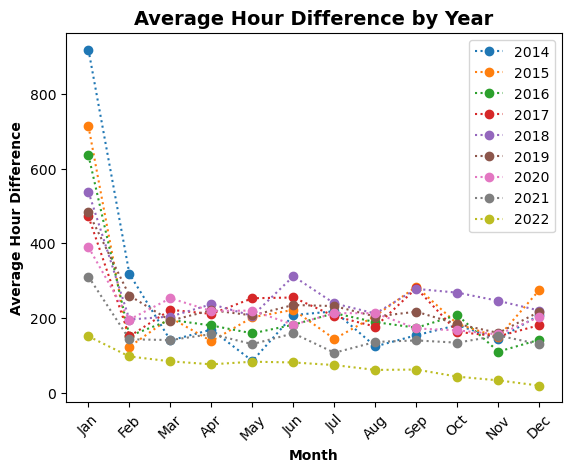

In [ ]:

fig, ax = plt.subplots()

# Define years for iteration
years = list(range(2014, 2023)) 

for year in years:
    col_name = f'HOUR_DIFF_{year}'
    ax.plot(hour_diff_df['MONTH'], hour_diff_df[col_name], label=str(year), marker='o', linestyle=':')

ax.set_xlabel('Month', fontdict={'weight': 700})
ax.set_ylabel('Average Hour Difference', fontdict={'weight': 700})
ax.set_title('Average Hour Difference by Year', fontdict={'weight': 700, 'size': 14})


ax.set_xticks(np.arange(12))
ax.set_xticklabels([m[0:3] for m in hour_diff_df['MONTH']])

ax.legend()
plt.xticks(rotation=45)
plt.show()



In [ ]:
# Create a new dataframe with the month and day difference for 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, and 2022
day_diff_df = pd.DataFrame(columns=['MONTH', 'DAY_DIFF_2014', 'DAY_DIFF_2015', 'DAY_DIFF_2016', 'DAY_DIFF_2017', 'DAY_DIFF_2018', 'DAY_DIFF_2019', 'DAY_DIFF_2020', 'DAY_DIFF_2021', 'DAY_DIFF_2022'])

# Loop through each month for each year and calculate the average day difference with no decimal places
for month in range(1, 13):
    day_diff_df.loc[month-1] = [month] + [round(sorted_df[(sorted_df['OCC_DATE'].dt.year == year) & (sorted_df['OCC_DATE'].dt.month == month)]['DAY_DIFFERENCE'].mean()) for year in range(2014, 2023)]

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
day_diff_df['MONTH'] = month_names

# Show the dataframe
day_diff_df


,MONTH,DAY_DIFF_2014,DAY_DIFF_2015,DAY_DIFF_2016,DAY_DIFF_2017,DAY_DIFF_2018,DAY_DIFF_2019,DAY_DIFF_2020,DAY_DIFF_2021,DAY_DIFF_2022
0,January,38,30,26,20,22,20,16,13,6
1,February,13,5,6,6,8,11,8,6,4
2,March,6,8,8,9,8,8,10,6,3
3,April,7,6,7,9,10,9,9,6,3
4,May,3,8,6,10,8,8,9,5,3
5,June,8,9,7,10,13,10,7,6,3
6,July,9,6,9,8,10,9,9,4,3
7,August,5,8,8,7,9,8,9,5,2
8,September,6,12,7,11,11,9,7,6,2
9,October,7,7,8,7,11,7,7,5,2


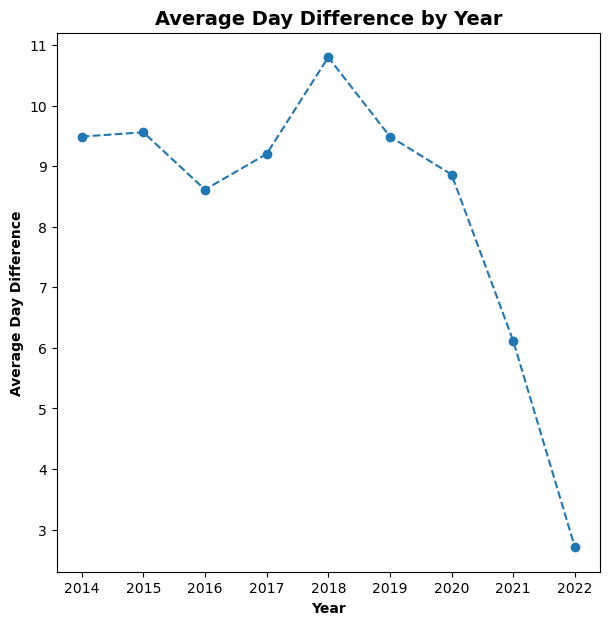

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

ax.plot(avg_diff_df['YEAR'], avg_diff_df['AVG_DAY_DIFF'], marker='o', linestyle='--')

ax.set_xlabel('Year', fontdict={'weight': 700})
ax.set_ylabel('Average Day Difference', fontdict={'weight': 700})
ax.set_title('Average Day Difference by Year', fontdict={'weight': 700, 'size': 14})


plt.show()

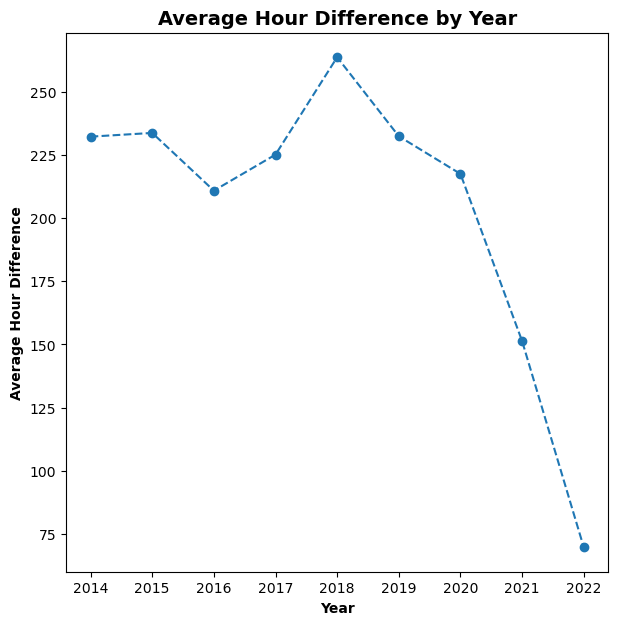

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

ax.plot(avg_diff_df['YEAR'], avg_diff_df['AVG_HOUR_DIFF'], marker='o', linestyle='--')

ax.set_xlabel('Year', fontdict={'weight': 700})
ax.set_ylabel('Average Hour Difference', fontdict={'weight': 700})
ax.set_title('Average Hour Difference by Year', fontdict={'weight': 700, 'size': 14})

plt.show()



## Question 4: Neighbourhoods Trends & Patterns
Can we identify trends or patterns in specific neighbourhoods? Is there a correlation between the type of offence and the premise?


In [ ]:
%matplotlib inline

In [ ]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
# plt.style.use('Solarize_Light2')
plt.style.use('bmh')

In [ ]:
#Read in csv file and inspect dataframe
file = pd.read_csv('../resources/mci_no_duplicates_2014_and_over.csv')
df = pd.DataFrame(file)
df.head()

,_id,EVENT_UNIQUE_ID,REPORT_DATE,OCC_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DAY,REPORT_DOY,REPORT_DOW,REPORT_HOUR,...,LOCATION_TYPE,PREMISES_TYPE,UCR_CODE,UCR_EXT,OFFENCE,MCI_CATEGORY,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140
0,2,GO-20141260701,2014-01-01,2014-01-01,2014,January,1,1,Wednesday,3.0,...,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",Commercial,2120,200,B&E,Break and Enter,70,South Riverdale,70,South Riverdale (70)
1,3,GO-20141260889,2014-01-01,2014-01-01,2014,January,1,1,Wednesday,4.0,...,"Apartment (Rooming House, Condo)",Apartment,1430,100,Assault,Assault,74,North St.James Town,74,North St.James Town (74)
2,4,GO-20141260973,2014-01-01,2014-01-01,2014,January,1,1,Wednesday,4.0,...,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,2130,210,Theft Over,Theft Over,NSA,NSA,NSA,NSA
3,5,GO-20141261050,2014-01-01,2014-01-01,2014,January,1,1,Wednesday,4.0,...,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,1430,100,Assault,Assault,69,Blake-Jones,66,Danforth (66)
4,6,GO-20141259344,2014-01-01,2014-01-01,2014,January,1,1,Wednesday,2.0,...,Bar / Restaurant,Commercial,1420,110,Assault Bodily Harm,Assault,164,Wellington Place,77,Waterfront Communities-The Island (77)


In [ ]:
#Keep only necessary columns
df = df[['EVENT_UNIQUE_ID', 'OCC_YEAR', 'OCC_MONTH', 'LOCATION_TYPE', 'PREMISES_TYPE', 'OFFENCE', 'MCI_CATEGORY', 'NEIGHBOURHOOD_158']]
df

,EVENT_UNIQUE_ID,OCC_YEAR,OCC_MONTH,LOCATION_TYPE,PREMISES_TYPE,OFFENCE,MCI_CATEGORY,NEIGHBOURHOOD_158
0,GO-20141260701,2014.0,January,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",Commercial,B&E,Break and Enter,South Riverdale
1,GO-20141260889,2014.0,January,"Apartment (Rooming House, Condo)",Apartment,Assault,Assault,North St.James Town
2,GO-20141260973,2014.0,January,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Theft Over,Theft Over,NSA
3,GO-20141261050,2014.0,January,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Assault,Assault,Blake-Jones
4,GO-20141259344,2014.0,January,Bar / Restaurant,Commercial,Assault Bodily Harm,Assault,Wellington Place
...,...,...,...,...,...,...,...,...
298467,GO-20222554300,2022.0,December,"Single Home, House (Attach Garage, Cottage, Mo...",House,B&E W'Intent,Break and Enter,Wexford/Maryvale
298468,GO-20222557893,2022.0,December,Other Commercial / Corporate Places (For Profi...,Commercial,B&E,Break and Enter,Milliken
298469,GO-20222559486,2022.0,December,"Apartment (Rooming House, Condo)",Apartment,Assault,Assault,Forest Hill North
298470,GO-20222557956,2022.0,December,Convenience Stores,Commercial,Assault,Assault,Rosedale-Moore Park


In [ ]:
#Check dtypes
df.dtypes

EVENT_UNIQUE_ID       object
OCC_YEAR             float64
OCC_MONTH             object
LOCATION_TYPE         object
PREMISES_TYPE         object
OFFENCE               object
MCI_CATEGORY          object
NEIGHBOURHOOD_158     object
dtype: object

In [ ]:
#Convert OCC_YEAR from float to integer 
df['OCC_YEAR'] = df['OCC_YEAR'].astype('int64')
df.dtypes

EVENT_UNIQUE_ID      object
OCC_YEAR              int64
OCC_MONTH            object
LOCATION_TYPE        object
PREMISES_TYPE        object
OFFENCE              object
MCI_CATEGORY         object
NEIGHBOURHOOD_158    object
dtype: object

In [ ]:
#Remove rows where NEIGHBOURHOOD_158 = NSA (no specified address) as per https://data.torontopolice.on.ca/datasets/TorontoPS::victims-of-crime-asr-vc-tbl-001/about
df = df.loc[df['NEIGHBOURHOOD_158'] != 'NSA']
df
#This removed about 5,000 rows of data

,EVENT_UNIQUE_ID,OCC_YEAR,OCC_MONTH,LOCATION_TYPE,PREMISES_TYPE,OFFENCE,MCI_CATEGORY,NEIGHBOURHOOD_158
0,GO-20141260701,2014,January,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",Commercial,B&E,Break and Enter,South Riverdale
1,GO-20141260889,2014,January,"Apartment (Rooming House, Condo)",Apartment,Assault,Assault,North St.James Town
3,GO-20141261050,2014,January,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Assault,Assault,Blake-Jones
4,GO-20141259344,2014,January,Bar / Restaurant,Commercial,Assault Bodily Harm,Assault,Wellington Place
5,GO-20141260233,2014,January,Other Commercial / Corporate Places (For Profi...,Commercial,B&E W'Intent,Break and Enter,Dorset Park
...,...,...,...,...,...,...,...,...
298467,GO-20222554300,2022,December,"Single Home, House (Attach Garage, Cottage, Mo...",House,B&E W'Intent,Break and Enter,Wexford/Maryvale
298468,GO-20222557893,2022,December,Other Commercial / Corporate Places (For Profi...,Commercial,B&E,Break and Enter,Milliken
298469,GO-20222559486,2022,December,"Apartment (Rooming House, Condo)",Apartment,Assault,Assault,Forest Hill North
298470,GO-20222557956,2022,December,Convenience Stores,Commercial,Assault,Assault,Rosedale-Moore Park


In [ ]:
#Rename columns
df = df.rename(columns = {'EVENT_UNIQUE_ID': 'EVENT_ID', 'NEIGHBOURHOOD_158': 'NEIGHBOURHOOD'})
df

,EVENT_ID,OCC_YEAR,OCC_MONTH,LOCATION_TYPE,PREMISES_TYPE,OFFENCE,MCI_CATEGORY,NEIGHBOURHOOD
0,GO-20141260701,2014,January,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",Commercial,B&E,Break and Enter,South Riverdale
1,GO-20141260889,2014,January,"Apartment (Rooming House, Condo)",Apartment,Assault,Assault,North St.James Town
3,GO-20141261050,2014,January,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Assault,Assault,Blake-Jones
4,GO-20141259344,2014,January,Bar / Restaurant,Commercial,Assault Bodily Harm,Assault,Wellington Place
5,GO-20141260233,2014,January,Other Commercial / Corporate Places (For Profi...,Commercial,B&E W'Intent,Break and Enter,Dorset Park
...,...,...,...,...,...,...,...,...
298467,GO-20222554300,2022,December,"Single Home, House (Attach Garage, Cottage, Mo...",House,B&E W'Intent,Break and Enter,Wexford/Maryvale
298468,GO-20222557893,2022,December,Other Commercial / Corporate Places (For Profi...,Commercial,B&E,Break and Enter,Milliken
298469,GO-20222559486,2022,December,"Apartment (Rooming House, Condo)",Apartment,Assault,Assault,Forest Hill North
298470,GO-20222557956,2022,December,Convenience Stores,Commercial,Assault,Assault,Rosedale-Moore Park


In [ ]:
#Rename location types for readability
renamed_locations = {'Other Commercial / Corporate Places (For Profit, Warehouse, Corp. Bldg': 'Other Commercial Places',
                    'Construction Site (Warehouse, Trailer, Shed)': 'Construction Site', 
                    'Single Home, House (Attach Garage, Cottage, Mobile)': 'Single Home/House',
                    'Parking Lots (Apt., Commercial Or Non-Commercial)': 'Parking Lots',
                    'Retirement Home': 'Retirement Home', 'Apartment (Rooming House, Condo)': 'Apartment',
                    'Streets, Roads, Highways (Bicycle Path, Private Road)': 'Streets, Roads, Highways',
                    'Bar / Restaurant': 'Bar/Restaurant', 'Ttc Bus Stop / Shelter / Loop': 'Public Transit',
                    'Schools During Supervised Activity': 'Schools, Supervised',
                    'Hospital / Institutions / Medical Facilities (Clinic, Dentist, Morgue)': 'Medical Facilities',
                    'Open Areas (Lakes, Parks, Rivers)': 'Open Areas', 'Dealership (Car, Motorcycle, Marine, Trailer, Etc.)': 'Dealership',
                    'Commercial Dwelling Unit (Hotel, Motel, B & B, Short Term Rental)': 'Commercial Dwelling Unit',
                    'Jails / Detention Centres': 'Jails/Detention Centres',
                    "Other Non Commercial / Corporate Places (Non-Profit, Gov'T, Firehall)": 'Other Non Commercial Places',
                    'Go Train': 'Public Transit', 'Private Property Structure (Pool, Shed, Detached Garage)': 'Private Property Structure',
                    'Religious Facilities (Synagogue, Church, Convent, Mosque)': 'Religious Facilities',
                    'Police / Courts (Parole Board, Probation Office)': 'Police/Courts', 'Convenience Stores': 'Convenience Stores',
                    'Gas Station (Self, Full, Attached Convenience)': 'Gas Stations', 'Go Station': 'Public Transit',
                    'Group Homes (Non-Profit, Halfway House, Social Agency)': 'Group Homes', 'Schools During Un-Supervised Activity': 'Schools, Unsupervised',
                    'Ttc Bus': 'Public Transit', 'Cargo Train': 'Cargo Train', 'Bank And Other Financial Institutions (Money Mart, Tsx)': 'Financial Institutions',
                    'Universities / Colleges': 'Secondary Education', 'Go Bus': 'Public Transit', 'Other Regional Transit System Vehicle': 'Public Transit',
                    'Nursing Home': 'Nursing Home', 'Community Group Home': 'Group Homes', 'Pharmacy': 'Pharmacy', 'Homeless Shelter / Mission': 'Homeless Shelters'}
df['LOCATION_TYPE'] = df['LOCATION_TYPE'].replace(renamed_locations)
df

,EVENT_ID,OCC_YEAR,OCC_MONTH,LOCATION_TYPE,PREMISES_TYPE,OFFENCE,MCI_CATEGORY,NEIGHBOURHOOD
0,GO-20141260701,2014,January,Commercial Dwelling Unit,Commercial,B&E,Break and Enter,South Riverdale
1,GO-20141260889,2014,January,Apartment,Apartment,Assault,Assault,North St.James Town
3,GO-20141261050,2014,January,"Streets, Roads, Highways",Outside,Assault,Assault,Blake-Jones
4,GO-20141259344,2014,January,Bar/Restaurant,Commercial,Assault Bodily Harm,Assault,Wellington Place
5,GO-20141260233,2014,January,Other Commercial Places,Commercial,B&E W'Intent,Break and Enter,Dorset Park
...,...,...,...,...,...,...,...,...
298467,GO-20222554300,2022,December,Single Home/House,House,B&E W'Intent,Break and Enter,Wexford/Maryvale
298468,GO-20222557893,2022,December,Other Commercial Places,Commercial,B&E,Break and Enter,Milliken
298469,GO-20222559486,2022,December,Apartment,Apartment,Assault,Assault,Forest Hill North
298470,GO-20222557956,2022,December,Convenience Stores,Commercial,Assault,Assault,Rosedale-Moore Park


In [ ]:
#Sort df by sum of events (offences) by neighbourhood
neighbourhood_total_offences = df.groupby('NEIGHBOURHOOD', as_index = False)['EVENT_ID'].count()
neighbourhood_total_offences

,NEIGHBOURHOOD,EVENT_ID
0,Agincourt North,1544
1,Agincourt South-Malvern West,2331
2,Alderwood,845
3,Annex,4391
4,Avondale,701
...,...,...
153,Yonge-Doris,1125
154,Yonge-Eglinton,1097
155,Yonge-St.Clair,615
156,York University Heights,5746


In [ ]:
#Sort from highest to lowest
sorted_neighbourhood_total_offences = neighbourhood_total_offences.sort_values(by = 'EVENT_ID', ascending = False)
sorted_neighbourhood_total_offences

,NEIGHBOURHOOD,EVENT_ID
139,West Humber-Clairville,8053
93,Moss Park,7320
36,Downtown Yonge East,6263
152,Yonge-Bay Corridor,5840
156,York University Heights,5746
...,...,...
155,Yonge-St.Clair,615
87,Maple Leaf,573
150,Woodbine-Lumsden,559
56,Guildwood,535


In [ ]:
#Store top 10 and bottom 10 neighbourhoods in lists
top_10_neighbourhood_names = list(sorted_neighbourhood_total_offences.head(10)['NEIGHBOURHOOD'])
bottom_10_neighbourhood_names = list(sorted_neighbourhood_total_offences.tail(10)['NEIGHBOURHOOD'])

In [ ]:
#Create 2 dataframes for the top 10 and bottom 10
top_10_df = df.loc[(df['NEIGHBOURHOOD'] == top_10_neighbourhood_names[0]) | (df['NEIGHBOURHOOD'] == top_10_neighbourhood_names[1]) | 
                   (df['NEIGHBOURHOOD'] == top_10_neighbourhood_names[2]) | (df['NEIGHBOURHOOD'] == top_10_neighbourhood_names[3]) | 
                   (df['NEIGHBOURHOOD'] == top_10_neighbourhood_names[4]) | (df['NEIGHBOURHOOD'] == top_10_neighbourhood_names[5]) | 
                   (df['NEIGHBOURHOOD'] == top_10_neighbourhood_names[6]) | (df['NEIGHBOURHOOD'] == top_10_neighbourhood_names[7]) | 
                   (df['NEIGHBOURHOOD'] == top_10_neighbourhood_names[8]) | (df['NEIGHBOURHOOD'] == top_10_neighbourhood_names[9])]

bottom_10_df = df.loc[(df['NEIGHBOURHOOD'] == bottom_10_neighbourhood_names[0]) | (df['NEIGHBOURHOOD'] == bottom_10_neighbourhood_names[1]) | 
                   (df['NEIGHBOURHOOD'] == bottom_10_neighbourhood_names[2]) | (df['NEIGHBOURHOOD'] == bottom_10_neighbourhood_names[3]) | 
                   (df['NEIGHBOURHOOD'] == bottom_10_neighbourhood_names[4]) | (df['NEIGHBOURHOOD'] == bottom_10_neighbourhood_names[5]) | 
                   (df['NEIGHBOURHOOD'] == bottom_10_neighbourhood_names[6]) | (df['NEIGHBOURHOOD'] == bottom_10_neighbourhood_names[7]) | 
                   (df['NEIGHBOURHOOD'] == bottom_10_neighbourhood_names[8]) | (df['NEIGHBOURHOOD'] == bottom_10_neighbourhood_names[9])]

## Top 10 Neighbourhoods

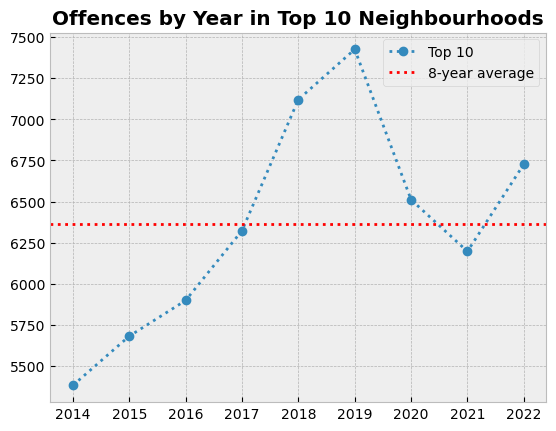

In [ ]:
#Group top 10 df by occurrence year and get the count of events
top_10_year = top_10_df.groupby('OCC_YEAR', as_index = False)['EVENT_ID'].count()
#Plot offences by year 
plt.plot(top_10_year['OCC_YEAR'], top_10_year['EVENT_ID'], 'o:', label = 'Top 10')
#Plot a horizontal line representing the 8-year average of offences in the top 10 neighbourhoods
plt.axhline(top_10_year['EVENT_ID'].mean(), label = '8-year average', color = 'r').set_linestyle(':')
#Set title and legend
plt.title('Offences by Year in Top 10 Neighbourhoods', fontdict = {'weight': 700})
plt.legend(loc = 'best')
plt.show()

In [ ]:
#Get the year over year % change in offences for the top 10 neighbourhoods
top_10_year['Pct Change YoY'] = top_10_year['EVENT_ID'].pct_change()
top_10_year

,OCC_YEAR,EVENT_ID,Pct Change YoY
0,2014,5383,NaN
1,2015,5682,0.055545
2,2016,5899,0.038191
3,2017,6323,0.071877
4,2018,7120,0.126048
5,2019,7425,0.042837
6,2020,6511,-0.123098
7,2021,6197,-0.048226
8,2022,6727,0.085525


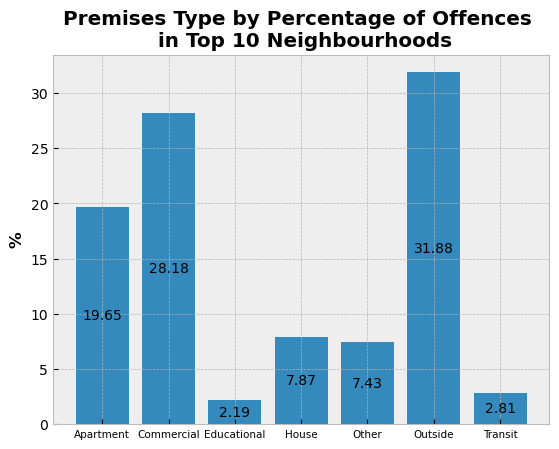

In [ ]:
#Premises type for top 10 neighbourhoods
top_10_premises = top_10_df.groupby('PREMISES_TYPE', as_index = False)['EVENT_ID'].count()
top_10_premises['Pct of Offences'] = round((top_10_premises['EVENT_ID'] / top_10_premises['EVENT_ID'].sum()) * 100, 2)

#Plot premises type
fig, ax = plt.subplots(nrows = 1, ncols = 1)
#Set font size of x ticks for readability
plt.rcParams['xtick.labelsize'] = 7.5
#Plot premises type
ax.bar(top_10_premises['PREMISES_TYPE'], top_10_premises['Pct of Offences'])
#Set bar labels
for container in ax.containers:
    ax.bar_label(container, label_type = 'center')
#Set title and y axis label
plt.title('Premises Type by Percentage of Offences \n in Top 10 Neighbourhoods', fontdict = {'weight': 700})
plt.ylabel('%', fontdict = {'weight': 700})
plt.show()

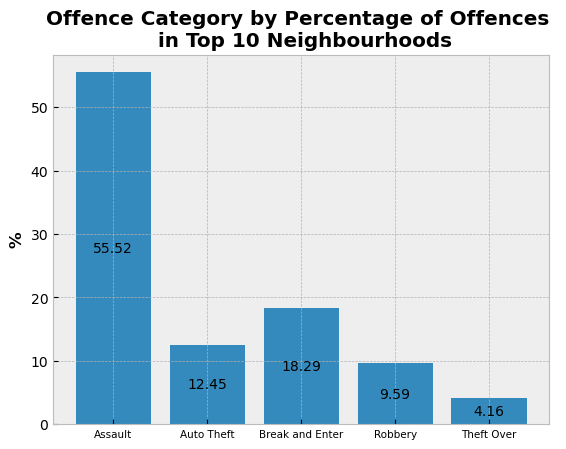

In [ ]:
#MCI categories for top 10 neighbourhoods
top_10_mci = top_10_df.groupby('MCI_CATEGORY', as_index = False)['EVENT_ID'].count()
top_10_mci['Pct of Offences'] = round((top_10_mci['EVENT_ID'] / top_10_mci['EVENT_ID'].sum()) * 100, 2)
#Plot MCI categories
fig, ax = plt.subplots(nrows = 1, ncols = 1)
#Set x ticks font size for readability
plt.rcParams['xtick.labelsize'] = 9
#Generate bar plot
ax.bar(top_10_mci['MCI_CATEGORY'], top_10_mci['Pct of Offences'])
#Set bar labels
for container in ax.containers:
    ax.bar_label(container, label_type = 'center')
#Set title and y axis label
plt.title('Offence Category by Percentage of Offences \n in Top 10 Neighbourhoods', fontdict = {'weight': 700})
plt.ylabel('%', fontdict = {'weight': 700})
plt.show()


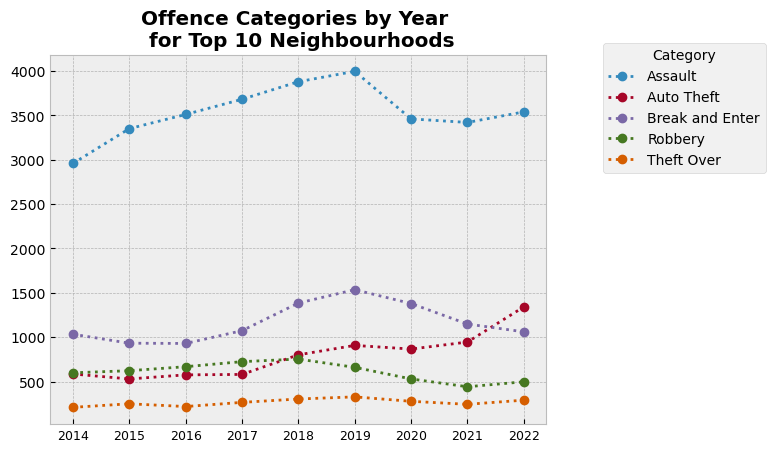

In [ ]:
#Plot MCI categories by year for top 10
#Create separate series for each MCI category
top_10_assault = top_10_df.loc[top_10_df['MCI_CATEGORY'] == 'Assault'].groupby('OCC_YEAR')['EVENT_ID'].count()
top_10_auto_theft = top_10_df.loc[top_10_df['MCI_CATEGORY'] == 'Auto Theft'].groupby('OCC_YEAR')['EVENT_ID'].count()
top_10_break_enter = top_10_df.loc[top_10_df['MCI_CATEGORY'] == 'Break and Enter'].groupby('OCC_YEAR')['EVENT_ID'].count()
top_10_robbery = top_10_df.loc[top_10_df['MCI_CATEGORY'] == 'Robbery'].groupby('OCC_YEAR')['EVENT_ID'].count()
top_10_theft_over = top_10_df.loc[top_10_df['MCI_CATEGORY'] == 'Theft Over'].groupby('OCC_YEAR')['EVENT_ID'].count()

#Generate figure and plots for each category
fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.plot(top_10_assault.index, top_10_assault.values, 'o:', label = 'Assault')
ax.plot(top_10_auto_theft.index, top_10_auto_theft.values, 'o:', label = 'Auto Theft')
ax.plot(top_10_break_enter.index, top_10_break_enter.values,'o:', label = 'Break and Enter')
ax.plot(top_10_robbery.index, top_10_robbery.values, 'o:', label = 'Robbery')
ax.plot(top_10_theft_over.index, top_10_theft_over.values, 'o:', label = 'Theft Over')

#Set title and legend
plt.title('Offence Categories by Year \n for Top 10 Neighbourhoods', fontdict = {'weight': 700})
plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Category')
plt.show()

## Bottom 10 Neighbourhoods

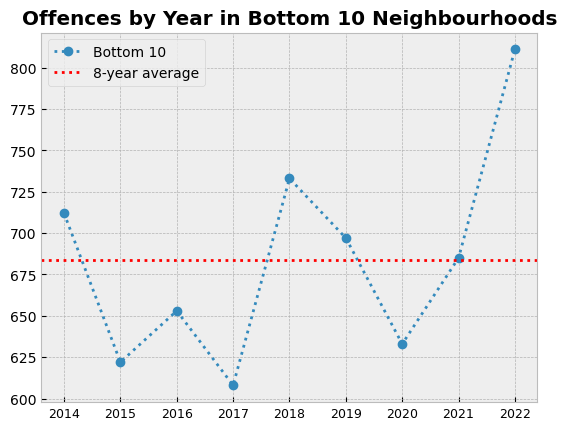

In [ ]:
#Group bottom 10 df by occurrence year and get the count of events (offences)
bottom_10_year = bottom_10_df.groupby('OCC_YEAR', as_index = False)['EVENT_ID'].count()
#Plot offences by year
plt.plot(bottom_10_year['OCC_YEAR'], bottom_10_year['EVENT_ID'], 'o:', label = 'Bottom 10')
#Plot a horizontal line representing the 8-year average of offences in the bottom 10 neighbourhoods
plt.axhline(bottom_10_year['EVENT_ID'].mean(), label = '8-year average', color = 'r').set_linestyle(':')
#Set title and legend
plt.title('Offences by Year in Bottom 10 Neighbourhoods', fontdict = {'weight': 700})
plt.legend(loc = 'best')
plt.show()

In [ ]:
#Get the year over year % change in offences for the bottom 10 neighbourhoods
bottom_10_year['Pct Change YoY'] = bottom_10_year['EVENT_ID'].pct_change()
bottom_10_year

,OCC_YEAR,EVENT_ID,Pct Change YoY
0,2014,712,NaN
1,2015,622,-0.126404
2,2016,653,0.049839
3,2017,608,-0.068913
4,2018,733,0.205592
5,2019,697,-0.049113
6,2020,633,-0.091822
7,2021,685,0.082148
8,2022,811,0.183942


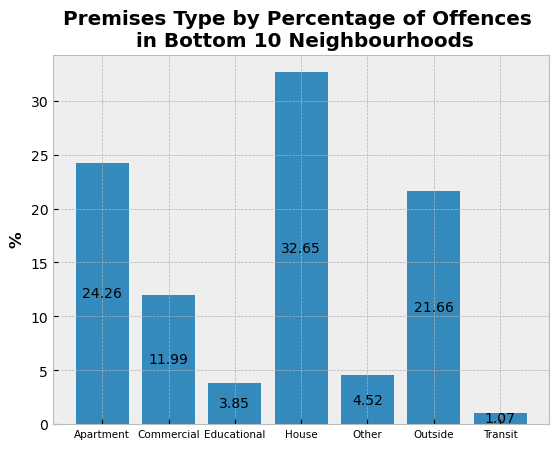

In [ ]:
#Premises type for bottom 10 neighbourhoods
bottom_10_premises = bottom_10_df.groupby('PREMISES_TYPE', as_index = False)['EVENT_ID'].count()
bottom_10_premises['Pct of Offences'] = round((bottom_10_premises['EVENT_ID'] / bottom_10_premises['EVENT_ID'].sum()) * 100, 2)

#Plot premises type
fig, ax = plt.subplots(nrows = 1, ncols = 1)
#Set font size of x ticks for readability
plt.rcParams['xtick.labelsize'] = 7.5
#Plot premises type
ax.bar(bottom_10_premises['PREMISES_TYPE'], bottom_10_premises['Pct of Offences'])
#Set bar labels
for container in ax.containers:
    ax.bar_label(container, label_type = 'center')
#Set title and y axis label
plt.title('Premises Type by Percentage of Offences \n in Bottom 10 Neighbourhoods', fontdict = {'weight': 700})
plt.ylabel('%', fontdict = {'weight': 700})
plt.show()

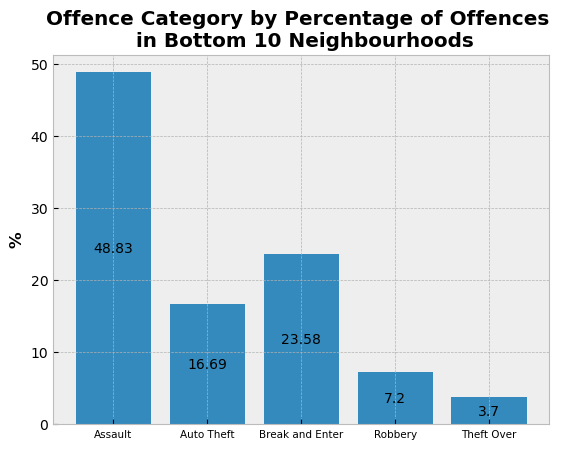

In [ ]:
#MCI categories for bottom 10 neighbourhoods
bottom_10_mci = bottom_10_df.groupby('MCI_CATEGORY', as_index = False)['EVENT_ID'].count()
bottom_10_mci['Pct of Offences'] = round((bottom_10_mci['EVENT_ID'] / bottom_10_mci['EVENT_ID'].sum()) * 100, 2)
#Plot MCI categories
fig, ax = plt.subplots(nrows = 1, ncols = 1)
#Set x ticks font size for readability
plt.rcParams['xtick.labelsize'] = 9
#Generate bar plot
ax.bar(bottom_10_mci['MCI_CATEGORY'], bottom_10_mci['Pct of Offences'])
#Set bar labels
for container in ax.containers:
    ax.bar_label(container, label_type = 'center')
#Set title and y axis label
plt.title('Offence Category by Percentage of Offences \n in Bottom 10 Neighbourhoods', fontdict = {'weight': 700})
plt.ylabel('%', fontdict = {'weight': 700})
plt.show()

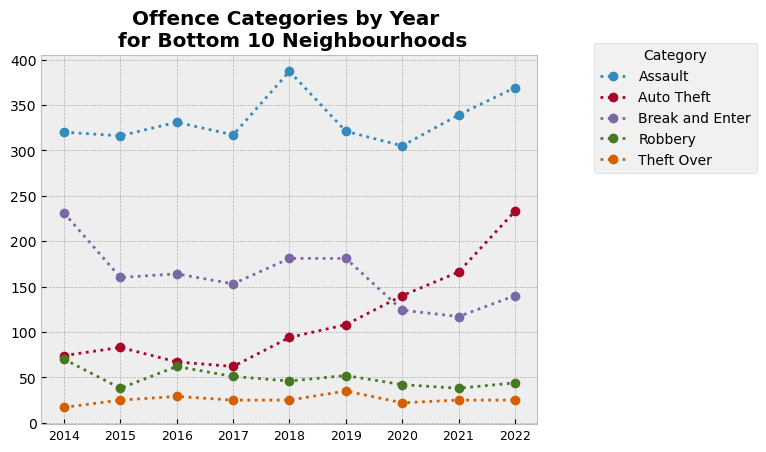

In [ ]:
#Plot MCI categories by year for bottom 10
#Create separate series for each MCI category
bottom_10_assault = bottom_10_df.loc[bottom_10_df['MCI_CATEGORY'] == 'Assault'].groupby('OCC_YEAR')['EVENT_ID'].count()
bottom_10_auto_theft = bottom_10_df.loc[bottom_10_df['MCI_CATEGORY'] == 'Auto Theft'].groupby('OCC_YEAR')['EVENT_ID'].count()
bottom_10_break_enter = bottom_10_df.loc[bottom_10_df['MCI_CATEGORY'] == 'Break and Enter'].groupby('OCC_YEAR')['EVENT_ID'].count()
bottom_10_robbery = bottom_10_df.loc[bottom_10_df['MCI_CATEGORY'] == 'Robbery'].groupby('OCC_YEAR')['EVENT_ID'].count()
bottom_10_theft_over = bottom_10_df.loc[bottom_10_df['MCI_CATEGORY'] == 'Theft Over'].groupby('OCC_YEAR')['EVENT_ID'].count()

#Generate figure and plots for each category
fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.plot(bottom_10_assault.index, bottom_10_assault.values, 'o:', label = 'Assault')
ax.plot(bottom_10_auto_theft.index, bottom_10_auto_theft.values, 'o:', label = 'Auto Theft')
ax.plot(bottom_10_break_enter.index, bottom_10_break_enter.values,'o:', label = 'Break and Enter')
ax.plot(bottom_10_robbery.index, bottom_10_robbery.values, 'o:', label = 'Robbery')
ax.plot(bottom_10_theft_over.index, bottom_10_theft_over.values, 'o:', label = 'Theft Over')

#Set title and legend
plt.title('Offence Categories by Year \n for Bottom 10 Neighbourhoods', fontdict = {'weight': 700})
plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Category')
plt.show()

## Year over Year Change in Neighbourhoods
### Analyze the neighbourhood with the greatest YoY increase, and the neighbourhood with the greatest YoY decrease.

In [ ]:
#Group df by neighbourhood and year, then get the count of MCI categories
neighbourhood_offences = df.groupby(['NEIGHBOURHOOD', 'OCC_YEAR'], as_index = False)['MCI_CATEGORY'].count()

In [ ]:
#Add a new column to neighbourhood_offences to calculate the year-over-year change in offences using .pct_change()
neighbourhood_offences['YoY % Change'] = (round(neighbourhood_offences['MCI_CATEGORY'].pct_change() * 100, 2))
#Change the values for 2014 to 0 as this dataset begins in 2014
neighbourhood_offences.loc[neighbourhood_offences['OCC_YEAR'] == 2014, 'YoY % Change'] = 0
neighbourhood_offences

,NEIGHBOURHOOD,OCC_YEAR,MCI_CATEGORY,YoY % Change
0,Agincourt North,2014,170,0.00
1,Agincourt North,2015,183,7.65
2,Agincourt North,2016,157,-14.21
3,Agincourt North,2017,175,11.46
4,Agincourt North,2018,226,29.14
...,...,...,...,...
1417,Yorkdale-Glen Park,2018,324,8.36
1418,Yorkdale-Glen Park,2019,400,23.46
1419,Yorkdale-Glen Park,2020,342,-14.50
1420,Yorkdale-Glen Park,2021,316,-7.60


In [ ]:
#Sort neighbourhood_offences by YoY % Change in descending order to get neighbourhoods with greatest YoY change
descending_neighbourhood_offences = neighbourhood_offences.sort_values(by = 'YoY % Change', ascending = False)
descending_neighbourhood_offences.head()

,NEIGHBOURHOOD,OCC_YEAR,MCI_CATEGORY,YoY % Change
462,Forest Hill South,2017,107,94.55
26,Alderwood,2022,148,89.74
453,Forest Hill North,2017,106,89.29
791,Maple Leaf,2022,111,85.00
867,Mount Pleasant East,2017,84,82.61


In [ ]:
#Sort neighbourhood_offences by YoY % Change in ascending order to get neighbourhoods with least YoY change
ascending_neighbourhood_offences = neighbourhood_offences.sort_values(by = 'YoY % Change')
ascending_neighbourhood_offences.head()

,NEIGHBOURHOOD,OCC_YEAR,MCI_CATEGORY,YoY % Change
555,Highland Creek,2020,59,-52.80
793,Markland Wood,2015,48,-47.25
786,Maple Leaf,2017,40,-45.95
780,Malvern West,2020,114,-43.00
690,Kingsway South,2020,54,-40.66


In [ ]:
#Separate highest (Forest Hill South) and lowest (Highland Creek) neighbourhood in their own dataframes
fhs_hood = df.loc[df['NEIGHBOURHOOD'] == 'Forest Hill South']
hc_hood = df.loc[df['NEIGHBOURHOOD'] == 'Highland Creek']

In [ ]:
#Define a function to generate 2 plots on the same figure showing the offence categories by month in the year before and year of
def year_comparison(year1, year2, df, hood, ylim):
    #Create 2 dataframes for the 2 years
    year1_df = df.loc[df['OCC_YEAR'] == year1]
    year2_df = df.loc[df['OCC_YEAR'] == year2]

    #Use pd.Categorical to sort months in chronological order in new dataframes
    months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    year1_df['OCC_MONTH'] = pd.Categorical(year1_df['OCC_MONTH'], categories = months, ordered = True)
    year2_df['OCC_MONTH'] = pd.Categorical(year2_df['OCC_MONTH'], categories = months, ordered = True)

    #Create figure with 2 subplots, set figure size and figure title weight using rcParams
    fig, ax = plt.subplots(nrows = 2, ncols = 1)
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.rcParams['figure.titleweight'] = 700

    #Year 1: For each MCI category, isolate rows from neighbourhood dataframe that correspond with the category and group by month to get the count
    year1_assault = year1_df.loc[year1_df['MCI_CATEGORY'] == 'Assault'].groupby('OCC_MONTH')['EVENT_ID'].count()
    year1_auto_theft = year1_df.loc[year1_df['MCI_CATEGORY'] == 'Auto Theft'].groupby('OCC_MONTH')['EVENT_ID'].count()
    year1_break_enter = year1_df.loc[year1_df['MCI_CATEGORY'] == 'Break and Enter'].groupby('OCC_MONTH')['EVENT_ID'].count()
    year1_robbery = year1_df.loc[year1_df['MCI_CATEGORY'] == 'Robbery'].groupby('OCC_MONTH')['EVENT_ID'].count()
    year1_theft_over = year1_df.loc[year1_df['MCI_CATEGORY'] == 'Theft Over'].groupby('OCC_MONTH')['EVENT_ID'].count()

    #Year 2: For each MCI category, isolate rows from neighbourhood dataframe that correspond with the category and group by month to get the count
    year2_assault = year2_df.loc[year2_df['MCI_CATEGORY'] == 'Assault'].groupby('OCC_MONTH')['EVENT_ID'].count()
    year2_auto_theft = year2_df.loc[year2_df['MCI_CATEGORY'] == 'Auto Theft'].groupby('OCC_MONTH')['EVENT_ID'].count()
    year2_break_enter = year2_df.loc[year2_df['MCI_CATEGORY'] == 'Break and Enter'].groupby('OCC_MONTH')['EVENT_ID'].count()
    year2_robbery = year2_df.loc[year2_df['MCI_CATEGORY'] == 'Robbery'].groupby('OCC_MONTH')['EVENT_ID'].count()
    year2_theft_over = year2_df.loc[year2_df['MCI_CATEGORY'] == 'Theft Over'].groupby('OCC_MONTH')['EVENT_ID'].count()
    
    #Create 5 line plots for each MCI category on the same plot for year 1
    ax[0].plot(year1_assault.index, year1_assault.values, label = 'Assault')
    ax[0].plot(year1_auto_theft.index, year1_auto_theft.values, label = 'Auto Theft')
    ax[0].plot(year1_break_enter.index, year1_break_enter.values, label = 'Break and Enter')
    ax[0].plot(year1_robbery.index, year1_robbery.values, label = 'Robbery')
    ax[0].plot(year1_theft_over.index, year1_theft_over.values, label = 'Theft Over')
    #Set ylim to match the scale of the y axis for ax[1]
    ax[0].set_ylim(0, ylim)
    #Set x ticks rotation and labels
    ax[0].set_xticks(ticks=np.arange(12), labels=[m[0:3] for m in year1_assault.index])
    #Set title and legend
    ax[0].set_title(year1, fontdict = {'weight': 700, 'size': 12})
    ax[0].legend(bbox_to_anchor=(1.05, .05), title = 'Category')   

    #Create 5 line plots for each MCI category on the same plot for year 2
    ax[1].plot(year2_assault.index, year2_assault.values, label = 'Assault')
    ax[1].plot(year2_auto_theft.index, year2_auto_theft.values, label = 'Auto Theft')
    ax[1].plot(year2_break_enter.index, year2_break_enter.values, label = 'Break and Enter')
    ax[1].plot(year2_robbery.index, year2_robbery.values, label = 'Robbery')
    ax[1].plot(year2_theft_over.index, year2_theft_over.values, label = 'Theft Over')
    #Set ylim for ax[0] and ax[1] x axes to match
    ax[1].set_ylim(0, ylim)
    #Set x ticks rotation and labels
    ax[1].set_xticks(ticks=np.arange(12), labels=[m[0:3] for m in year2_assault.index])
    #Set title and legend
    ax[1].set_title(year2, fontdict = {'weight': 700, 'size': 12})

    #Set figure title
    fig.suptitle(f'Offence Categories by Month for {hood}, {year1}-{year2}')

    #Adjust space between subplots for readability and show figure
    plt.subplots_adjust(hspace = 0.5)
    plt.show()

    


/var/folders/m2/ysnn55010957_py0m5n5dds40000gn/T/ipykernel_89954/3845246449.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year1_df['OCC_MONTH'] = pd.Categorical(year1_df['OCC_MONTH'], categories = months, ordered = True)
/var/folders/m2/ysnn55010957_py0m5n5dds40000gn/T/ipykernel_89954/3845246449.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year2_df['OCC_MONTH'] = pd.Categorical(year2_df['OCC_MONTH'], categories = months, ordered = True)


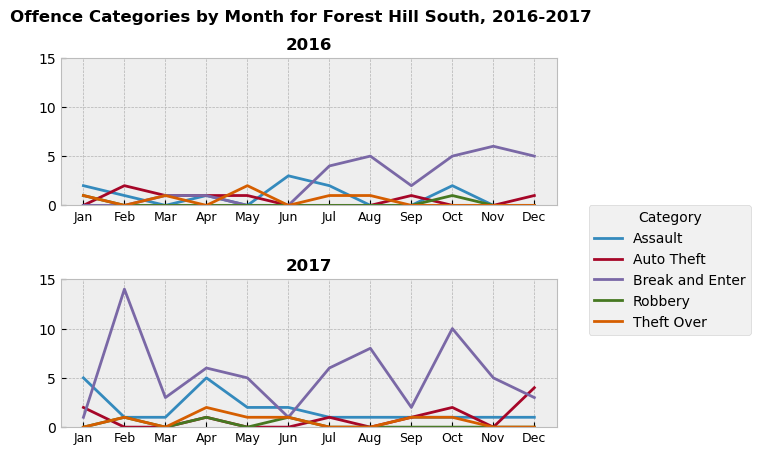

In [ ]:
#Call year_comparison function for Forest Hill South, 2016 vs 2017
year_comparison(2016, 2017, fhs_hood, 'Forest Hill South', 15)

In [ ]:
#Get percentage change in offence categories 2016 vs 2017 for Forest Hill South
fhs_2016_off = fhs_hood.loc[fhs_hood['OCC_YEAR'] == 2016].groupby(['OCC_YEAR', 'MCI_CATEGORY'], as_index = False)['EVENT_ID'].count()
fhs_2017_off = fhs_hood.loc[fhs_hood['OCC_YEAR'] == 2017].groupby(['OCC_YEAR', 'MCI_CATEGORY'], as_index = False)['EVENT_ID'].count()
print(fhs_2016_off)
print(fhs_2017_off)

   OCC_YEAR     MCI_CATEGORY  EVENT_ID
0      2016          Assault        11
1      2016       Auto Theft         7
2      2016  Break and Enter        29
3      2016          Robbery         2
4      2016       Theft Over         6
   OCC_YEAR     MCI_CATEGORY  EVENT_ID
0      2017          Assault        22
1      2017       Auto Theft        11
2      2017  Break and Enter        64
3      2017          Robbery         3
4      2017       Theft Over         7


/var/folders/m2/ysnn55010957_py0m5n5dds40000gn/T/ipykernel_89954/3845246449.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year1_df['OCC_MONTH'] = pd.Categorical(year1_df['OCC_MONTH'], categories = months, ordered = True)
/var/folders/m2/ysnn55010957_py0m5n5dds40000gn/T/ipykernel_89954/3845246449.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year2_df['OCC_MONTH'] = pd.Categorical(year2_df['OCC_MONTH'], categories = months, ordered = True)


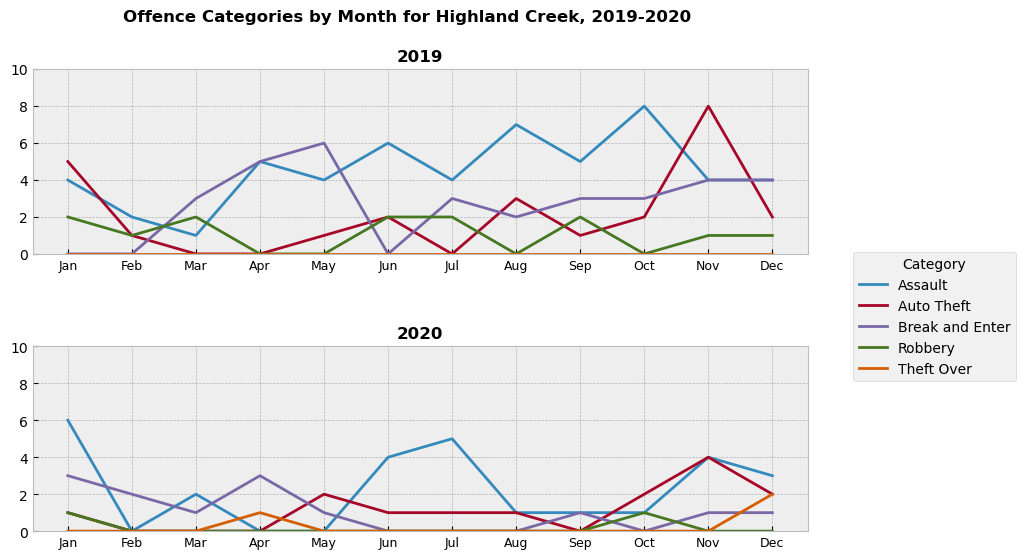

In [ ]:
#Call year_comparison function for Highland Creek, 2019-2020
year_comparison(2019, 2020, hc_hood, 'Highland Creek', 10)

In [ ]:
#Get percentage change in offence categories 2019 vs 2020 for Highland Creek
hc_2019_off = hc_hood.loc[hc_hood['OCC_YEAR'] == 2019].groupby(['OCC_YEAR', 'MCI_CATEGORY'], as_index = False)['EVENT_ID'].count()
hc_2020_off = hc_hood.loc[hc_hood['OCC_YEAR'] == 2020].groupby(['OCC_YEAR', 'MCI_CATEGORY'], as_index = False)['EVENT_ID'].count()
print(hc_2019_off)
print(hc_2020_off)

   OCC_YEAR     MCI_CATEGORY  EVENT_ID
0      2019          Assault        54
1      2019       Auto Theft        25
2      2019  Break and Enter        33
3      2019          Robbery        13
   OCC_YEAR     MCI_CATEGORY  EVENT_ID
0      2020          Assault        27
1      2020       Auto Theft        14
2      2020  Break and Enter        13
3      2020          Robbery         2
4      2020       Theft Over         3


## Correlation between Premises Type and MCI Category

In [ ]:
#Group df by MCI category and occurence month, then get count of events
grouped_cat_month = df.groupby(['MCI_CATEGORY', 'OCC_MONTH'], as_index = False)['EVENT_ID'].count()
grouped_cat_month

,MCI_CATEGORY,OCC_MONTH,EVENT_ID
0,Assault,April,12054
1,Assault,August,13743
2,Assault,December,12439
3,Assault,February,10966
4,Assault,January,11976
5,Assault,July,14238
6,Assault,June,13795
7,Assault,March,12158
8,Assault,May,13751
9,Assault,November,12657


In [ ]:
#Make a copy of the dataframe to reorder the months
grouped_cat_month_copy = grouped_cat_month.copy()
grouped_cat_month_copy.head()

,MCI_CATEGORY,OCC_MONTH,EVENT_ID
0,Assault,April,12054
1,Assault,August,13743
2,Assault,December,12439
3,Assault,February,10966
4,Assault,January,11976


In [ ]:
#Reorder the months chronologically with pd.Categorical
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
grouped_cat_month_copy['OCC_MONTH'] = pd.Categorical(grouped_cat_month_copy['OCC_MONTH'], categories = months, ordered = True) 

In [ ]:
#Sort by month
grouped_cat_month_copy.sort_values(by = 'OCC_MONTH', inplace = True)
grouped_cat_month_copy

,MCI_CATEGORY,OCC_MONTH,EVENT_ID
28,Break and Enter,January,5239
4,Assault,January,11976
40,Robbery,January,2153
16,Auto Theft,January,2999
52,Theft Over,January,780
15,Auto Theft,February,2772
27,Break and Enter,February,4486
3,Assault,February,10966
39,Robbery,February,1958
51,Theft Over,February,724


In [ ]:
#Group df by premises type and occurrence month to get the count of events
grouped_premises_type = df.groupby(['PREMISES_TYPE', 'OCC_MONTH'], as_index = False)['EVENT_ID'].count()

In [ ]:
#Copy grouped_premises_type to reorder months using pd.Categorical
grouped_premises_copy = grouped_premises_type.copy()

In [ ]:
#Order months in chronological order using pd.Categorical
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
grouped_premises_copy['OCC_MONTH'] = pd.Categorical(grouped_premises_copy['OCC_MONTH'], categories = months, ordered = True)

In [ ]:
#Sort df by occurence month
grouped_premises_copy.sort_values(by = 'OCC_MONTH', inplace = True)
grouped_premises_copy

,PREMISES_TYPE,OCC_MONTH,EVENT_ID
28,Educational,January,560
64,Outside,January,4877
16,Commercial,January,5025
4,Apartment,January,6229
40,House,January,4338
...,...,...,...
74,Transit,December,760
50,Other,December,1360
62,Outside,December,5409
2,Apartment,December,6241


In [ ]:
#Define function to generate scatter plot and linear regression for a category and a premise type, as well as print the r-squared and the Pearson r
def premise_cat_scatter(category, premise):
    #Use .loc to get dataframes for the premise and the category
    category_df = grouped_cat_month_copy.loc[grouped_cat_month_copy['MCI_CATEGORY'] == category]
    premise_df = grouped_premises_copy.loc[grouped_premises_copy['PREMISES_TYPE'] == premise]

    #Linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(category_df['EVENT_ID'], premise_df['EVENT_ID'])
    regress_values = category_df['EVENT_ID'] * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    #R-squared
    print(f'The r-squared is {rvalue**2}.')

    #Correlation (pearson r)
    correlation = st.pearsonr(category_df['EVENT_ID'], premise_df['EVENT_ID'])
    print(f'The correlation between {category} and {premise} is {correlation[0]}.')

    #Generate scatter plot, set title and axis labels
    plt.scatter(category_df['EVENT_ID'], premise_df['EVENT_ID'])
    plt.title(f'{category} vs {premise}')
    plt.xlabel(f'{category}')
    plt.ylabel(f'{premise}')

    #Plot linear regression line equation
    plt.plot(category_df['EVENT_ID'],regress_values,"r-")

    plt.show()

The r-squared is 0.8955820355770051.
The correlation between Assault and Outside is 0.9463519617864196.


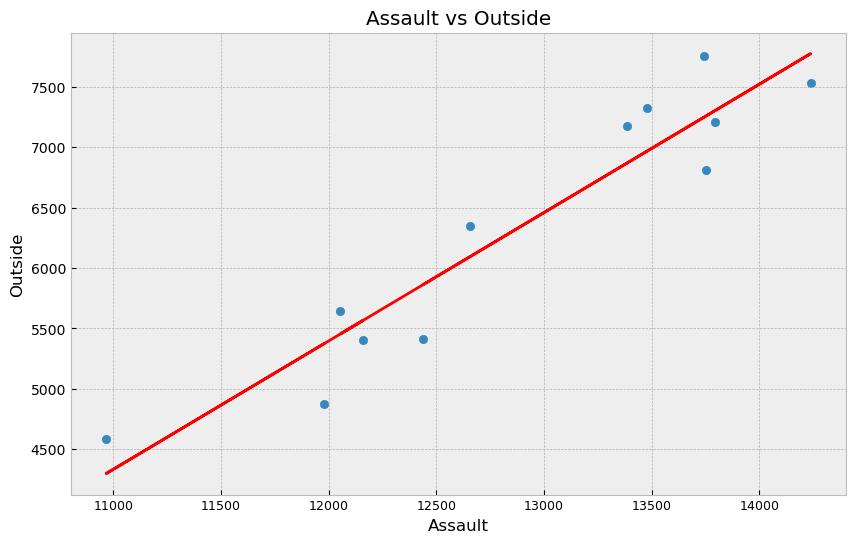

In [ ]:
#Call premise_cat_scatter function for Assault and Outside
premise_cat_scatter('Assault', 'Outside')

The r-squared is 0.8111849501888441.
The correlation between Auto Theft and House is 0.900658065077332.


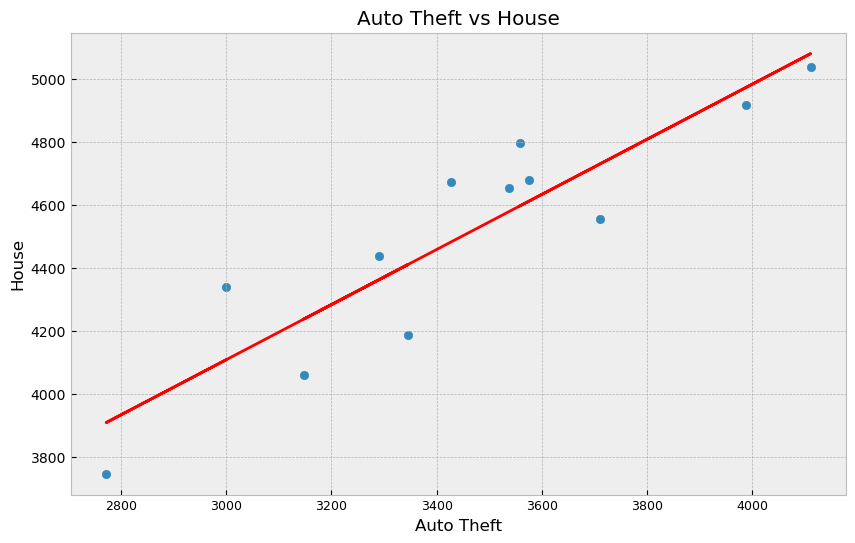

In [ ]:
#Call premise_cat_scatter function for Auto Theft and House
premise_cat_scatter('Auto Theft', 'House')

The r-squared is 0.5941430339807302.
The correlation between Break and Enter and Commercial is 0.7708067423036268.


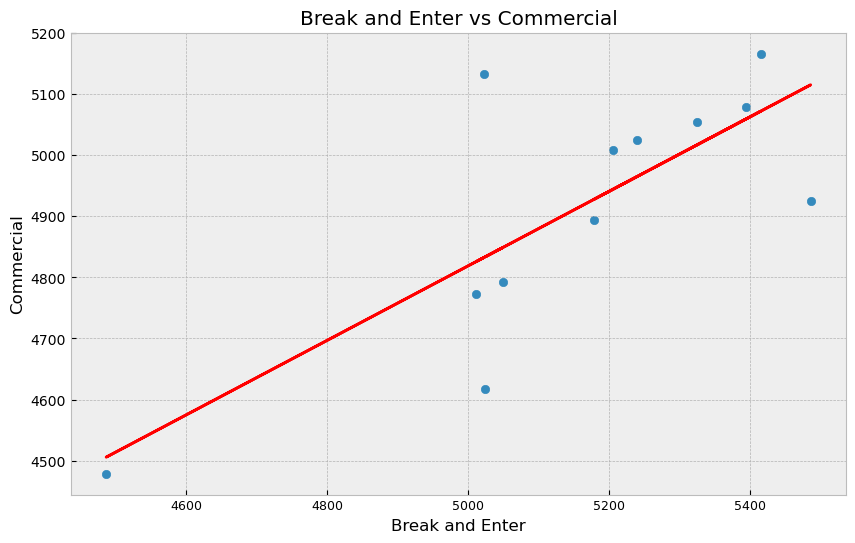

In [ ]:
#Call premise_cat_scatter function for Break and Enter and Commercial
premise_cat_scatter('Break and Enter', 'Commercial')

The r-squared is 0.7701689828679038.
The correlation between Break and Enter and House is 0.8775927203822419.


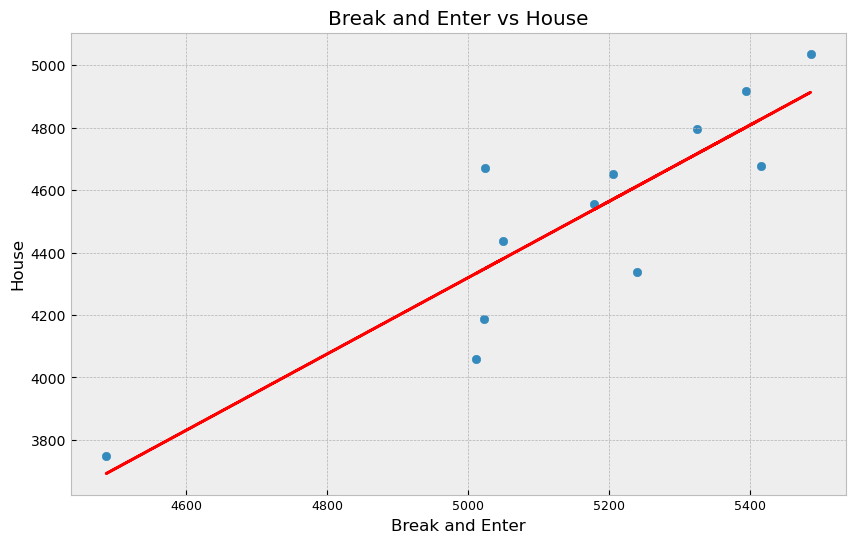

In [ ]:
#Call premise_cat_scatter function for Break and Enter and House
premise_cat_scatter('Break and Enter', 'House')

The r-squared is 0.550881227447354.
The correlation between Robbery and Other is 0.7422137343429815.


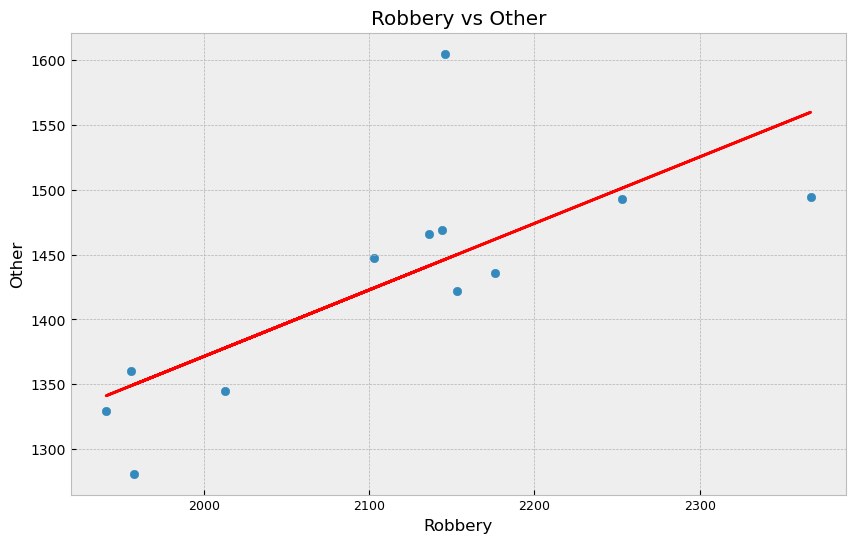

In [ ]:
#Call premise_cat_scatter function for Robbery and Outside
premise_cat_scatter('Robbery', 'Other')

The r-squared is 0.7962000330997377.
The correlation between Theft Over and House is 0.8923004163955871.


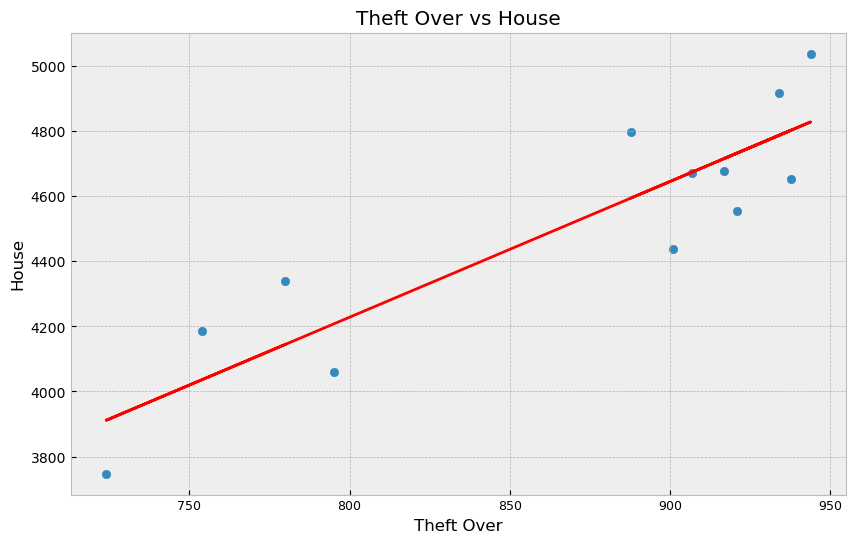

In [ ]:
#Call premise_cat_scatter function for Theft Over and House
premise_cat_scatter('Theft Over', 'House')

The r-squared is 0.7434820289015519.
The correlation between Theft Over and Outside is 0.8622540396551079.


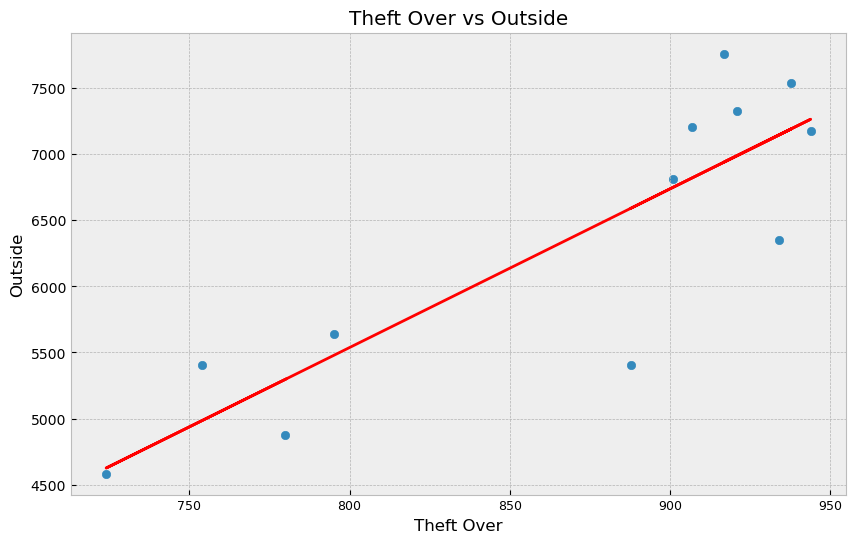

In [ ]:
#Call premise_cat_scatter function for Theft Over and Outside
premise_cat_scatter('Theft Over', 'Outside')

## Question 5

Is there a correlation between certain types of offences (e.g. do areas with high drug-related crimes also see increased violent crimes)?

In [ ]:
# Dependencies
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# plt.style.use('Solarize_Light2')
plt.style.use('bmh')

In [ ]:
# Read in datasets from mci_no_duplicates_2014_and_over.csv
df = pd.read_csv(Path('../Resources/mci_no_duplicates_2014_and_over.csv'))

# Create a data frame with only the columns we need HOOD_158, OCC_YEAR, LOCATION_TYPE, PREMISES_TYPE, OFFENCE, MCI_CATEGORY
df = df[['NEIGHBOURHOOD_158', 'OCC_YEAR', 'LOCATION_TYPE', 'PREMISES_TYPE', 'OFFENCE', 'MCI_CATEGORY']]

# Drop all rows with NaN values
df = df.dropna()

# Print the first 5 rows of the data frame
df.head()

,NEIGHBOURHOOD_158,OCC_YEAR,LOCATION_TYPE,PREMISES_TYPE,OFFENCE,MCI_CATEGORY
0,South Riverdale,2014.0,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",Commercial,B&E,Break and Enter
1,North St.James Town,2014.0,"Apartment (Rooming House, Condo)",Apartment,Assault,Assault
2,NSA,2014.0,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Theft Over,Theft Over
3,Blake-Jones,2014.0,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Assault,Assault
4,Wellington Place,2014.0,Bar / Restaurant,Commercial,Assault Bodily Harm,Assault


In [ ]:
# Drop all rows with NaN values
df = df.dropna()

In [ ]:
# Calculate the number of unique values in the offence column
print(f"Total number of offence types are {len(df['OFFENCE'].unique())}")
print(f"Total number of MCI Categories are {len(df['MCI_CATEGORY'].unique())}")

Total number of offence types are 51
Total number of MCI Categories are 5


In [ ]:
# show the offence types most common
df['OFFENCE'].value_counts()

Assault                           109634
B&E                                52616
Theft Of Motor Vehicle             41948
Assault With Weapon                25702
B&E W'Intent                        7659
Robbery - Mugging                   7567
Assault Bodily Harm                 6957
Theft Over                          5869
Robbery - Other                     4558
Assault Peace Officer               4340
Robbery With Weapon                 4205
Robbery - Business                  3857
Assault - Resist/ Prevent Seiz      2664
Theft From Motor Vehicle Over       2620
Aggravated Assault                  2332
Unlawfully In Dwelling-House        1926
Robbery - Swarming                  1905
Discharge Firearm With Intent       1696
Discharge Firearm - Recklessly      1367
Theft From Mail / Bag / Key         1293
Pointing A Firearm                  1065
Robbery - Purse Snatch              1000
Robbery - Financial Institute        838
Robbery - Vehicle Jacking            802
Robbery - Home I

In [ ]:
# show the MCI categories with most crimes
df['MCI_CATEGORY'].value_counts()

Assault            157442
Break and Enter     62330
Auto Theft          41948
Robbery             26143
Theft Over          10609
Name: MCI_CATEGORY, dtype: int64

In [ ]:
# Calculate the number of offences for each Neighbourhood (keep neighbourhood names)
df['NEIGHBOURHOOD_158'].value_counts()
# Create a data frame and sort the number of crimes in descending order
df_neighbourhood = pd.DataFrame(df['NEIGHBOURHOOD_158'].value_counts()).reset_index()
df_neighbourhood.columns = ['Neighbourhood', 'Number of Crimes']
# Get top 10 neighbourhoods with most crimes into new data frame
df_neighbourhood_top_10 = df_neighbourhood.head(10)
df_neighbourhood_top_10



,Neighbourhood,Number of Crimes
0,West Humber-Clairville,8053
1,Moss Park,7320
2,Downtown Yonge East,6263
3,Yonge-Bay Corridor,5840
4,York University Heights,5746
5,Wellington Place,5669
6,Kensington-Chinatown,5333
7,NSA,4786
8,West Hill,4648
9,Annex,4391


In [ ]:
# Add each MCI_CATEGORY as a column to the data frame
df_neighbourhood_top_10['Assault'] = ''
df_neighbourhood_top_10['Auto Theft'] = ''
df_neighbourhood_top_10['Break and Enter'] = ''
df_neighbourhood_top_10['Robbery'] = ''
df_neighbourhood_top_10['Theft Over'] = ''
# Calculate the number of crimes for each MCI_CATEGORY and add to the data frame
for index, row in df_neighbourhood_top_10.iterrows():
    df_neighbourhood_top_10.loc[index, 'Assault'] = df[(df['NEIGHBOURHOOD_158'] == row['Neighbourhood']) & (df['MCI_CATEGORY'] == 'Assault')]['MCI_CATEGORY'].count()
    df_neighbourhood_top_10.loc[index, 'Auto Theft'] = df[(df['NEIGHBOURHOOD_158'] == row['Neighbourhood']) & (df['MCI_CATEGORY'] == 'Auto Theft')]['MCI_CATEGORY'].count()
    df_neighbourhood_top_10.loc[index, 'Break and Enter'] = df[(df['NEIGHBOURHOOD_158'] == row['Neighbourhood']) & (df['MCI_CATEGORY'] == 'Break and Enter')]['MCI_CATEGORY'].count()
    df_neighbourhood_top_10.loc[index, 'Robbery'] = df[(df['NEIGHBOURHOOD_158'] == row['Neighbourhood']) & (df['MCI_CATEGORY'] == 'Robbery')]['MCI_CATEGORY'].count()
    df_neighbourhood_top_10.loc[index, 'Theft Over'] = df[(df['NEIGHBOURHOOD_158'] == row['Neighbourhood']) & (df['MCI_CATEGORY'] == 'Theft Over')]['MCI_CATEGORY'].count()
# Print the data frame
df_neighbourhood_top_10



/var/folders/sr/dhgj0pd556lbz6w83rl0mc7c0000gn/T/ipykernel_51469/2231483911.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neighbourhood_top_10['Assault'] = ''
/var/folders/sr/dhgj0pd556lbz6w83rl0mc7c0000gn/T/ipykernel_51469/2231483911.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neighbourhood_top_10['Auto Theft'] = ''
/var/folders/sr/dhgj0pd556lbz6w83rl0mc7c0000gn/T/ipykernel_51469/2231483911.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,Neighbourhood,Number of Crimes,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,West Humber-Clairville,8053,2311,3466,1170,625,481
1,Moss Park,7320,4468,303,1366,1023,160
2,Downtown Yonge East,6263,3882,268,1090,830,193
3,Yonge-Bay Corridor,5840,3840,175,966,516,343
4,York University Heights,5746,2741,1103,1031,518,353
5,Wellington Place,5669,3641,301,1183,349,195
6,Kensington-Chinatown,5333,3102,265,1271,463,232
7,NSA,4786,2803,484,496,797,206
8,West Hill,4648,3133,321,666,464,64
9,Annex,4391,2156,249,1386,328,272


In [ ]:
# Remove "number of crimes" column
df_neighbourhood_top_10 = df_neighbourhood_top_10.drop(columns=['Number of Crimes'])
#df_neighbourhood_top_10 = df_neighbourhood_top_10.rename(columns={'Number of Crimes': 'Total'})
# Calculate the percentage of each MCI_CATEGORY and add to the data frame
#df_neighbourhood_top_10['Assault %'] = df_neighbourhood_top_10['Assault'] / df_neighbourhood_top_10['Total'] * 100
#df_neighbourhood_top_10['Auto Theft %'] = df_neighbourhood_top_10['Auto Theft'] / df_neighbourhood_top_10['Total'] * 100
#df_neighbourhood_top_10['Break and Enter %'] = df_neighbourhood_top_10['Break and Enter'] / df_neighbourhood_top_10['Total'] * 100
#df_neighbourhood_top_10['Robbery %'] = df_neighbourhood_top_10['Robbery'] / df_neighbourhood_top_10['Total'] * 100
#df_neighbourhood_top_10['Theft Over %'] = df_neighbourhood_top_10['Theft Over'] / df_neighbourhood_top_10['Total'] * 100
# Print the data frame
df_neighbourhood_top_10

,Neighbourhood,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,West Humber-Clairville,2311,3466,1170,625,481
1,Moss Park,4468,303,1366,1023,160
2,Downtown Yonge East,3882,268,1090,830,193
3,Yonge-Bay Corridor,3840,175,966,516,343
4,York University Heights,2741,1103,1031,518,353
5,Wellington Place,3641,301,1183,349,195
6,Kensington-Chinatown,3102,265,1271,463,232
7,NSA,2803,484,496,797,206
8,West Hill,3133,321,666,464,64
9,Annex,2156,249,1386,328,272


/var/folders/sr/dhgj0pd556lbz6w83rl0mc7c0000gn/T/ipykernel_51469/850006415.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_neighbourhood_top_10.corr()


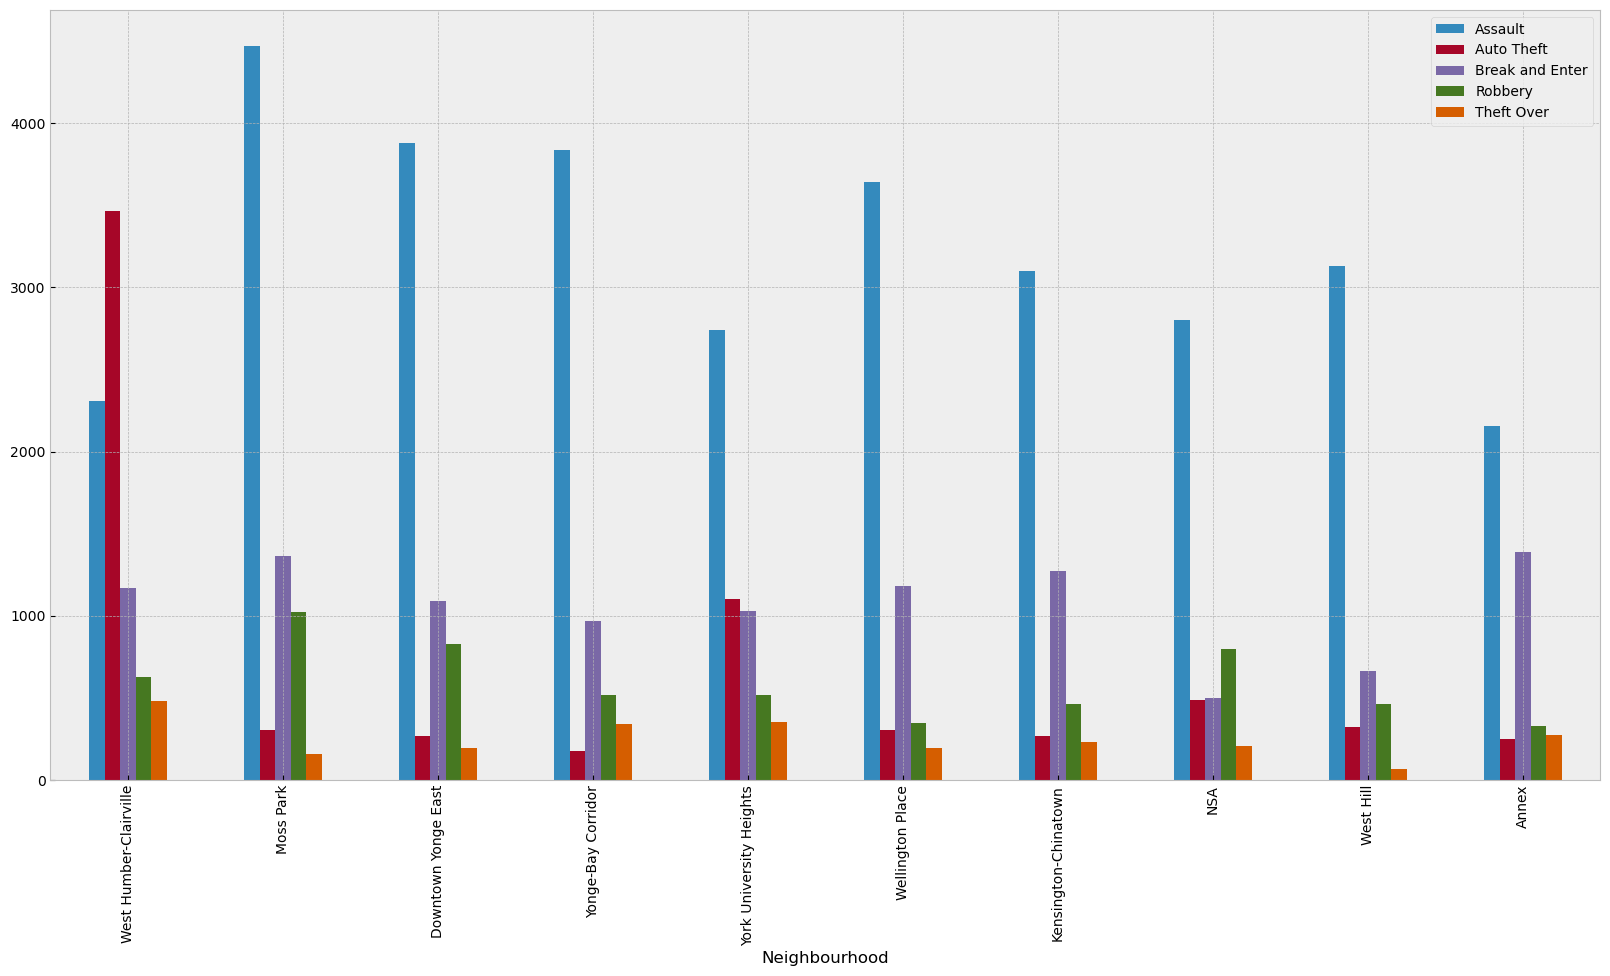

In [ ]:
# Correlation between the number of crimes and the number of each MCI_CATEGORY
df_neighbourhood_top_10.corr()
# Plot the data frame
df_neighbourhood_top_10.plot.bar(x='Neighbourhood', y=['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over'], figsize=(20,10))
# save the plot
plt.savefig('q4-1.png')

In [ ]:
# Convert all data to numeric
df_neighbourhood_top_10 = df_neighbourhood_top_10.apply(pd.to_numeric, errors='ignore')

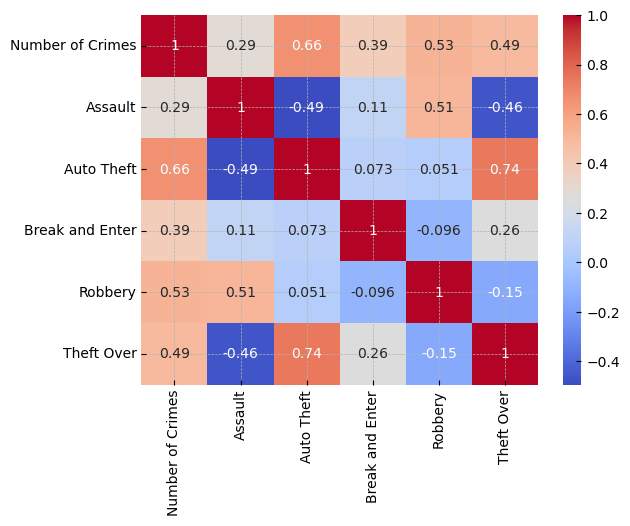

<Figure size 640x480 with 0 Axes>

In [ ]:
# Calculate the correlation between the number of crimes and the number of each MCI_CATEGORY
corr = df_neighbourhood_top_10.drop('Neighbourhood', axis=1).corr()
# Plot the correlation
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()
# save the figure as a png file
plt.savefig('q4.png')

